In [149]:
%reload_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

from pathlib import Path
from sys import path
from typing import Dict, List

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns
import statsmodels.api as sm
from pymc_marketing.clv import ParetoNBDModel, plot_expected_purchases_over_time
from pymc_marketing.clv.models.gamma_gamma import GammaGammaModel
from pymc_marketing.clv.utils import rfm_train_test_split
from pymc_marketing.prior import Prior
from scipy.stats import gamma, kendalltau, pearsonr, spearmanr
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from sklearn.preprocessing import RobustScaler, SplineTransformer
from statsmodels.genmod.generalized_linear_model import GLMResultsWrapper
from statsmodels.robust.robust_linear_model import RLM, RLMResultsWrapper
from tqdm import tqdm
from xarray import DataArray, concat

path.append(str(Path.cwd().parent))
from src.model_utils import (
    create_btyd_model_config_mle,
    create_spend_model_config_mle,
    run_pnbd_ppcs,
)

## Globals

In [2]:
pd.set_option("mode.copy_on_write", True)

az.style.use("arviz-darkgrid")

seed: int = 27

random_state: np.random.RandomState = np.random.RandomState(seed=seed)

rng: np.random.Generator = np.random.default_rng(seed=seed)

In [3]:
data_path: Path = Path.cwd().parent / "data" / "processed"
model_path: Path = Path.cwd().parent / "models"

for path in [model_path]:
    Path(path).mkdir(parents=True, exist_ok=True)

## Data

PyMC Marketing, as of version 0.11.1, still works primarily with numpy-based data types; we convert from newer pandas data types back to numpy-based data types. For example, if `pd.StringDtype` is used for the ID column, models cannot be properly saved and loaded.

In [4]:
data = pd.read_parquet(data_path / "transactions.parquet")

data = data.astype({"account_number": str, "transaction_amount": float})

data.dtypes

transaction_amount             float64
account_number                  object
transaction_datetime    datetime64[ns]
dtype: object

Keep only non-zero transactions only:

In [5]:
zero_counts = data[data["transaction_amount"] == 0].shape[0]

zero_counts

22103

In [6]:
data = data.loc[data["transaction_amount"] > 0]

data.shape

(751843, 3)

### Aggregate Data for Modeling

This dataset summarizes customer purchasing behavior using the RFM (Recency, Frequency, Monetary) model, which is commonly used for customer segmentation and lifetime valuation estimation.

- **`customer_id`**: Unique identifier for each customer, corresponding to the `account_number` in the original transactions dataset.

- **`frequency`**: The total number of repeat purchases made by the account. It is calculated as the total number of transactions **minus one** (since the first purchase isn't considered a repeat). For example, if a customer has made 5 purchases, their frequency will be 4.

- **`recency`**: The time elapsed (in **days**) between the account's most recent purchase and the end of the observation period. A **lower recency** value indicates a more recent purchase, while a **higher recency** implies the account hasn't made a purchase recently.  
  - **Note**: If an account has only made one purchase, `recency` is set to **0**.

- **`T`**: The customer’s “age” or tenure, measured in **days**. It represents the time between a customer’s first purchase and the end of the observation period. This metric indicates how long the customer has been active.

- **`monetary_value`**: The average amount spent per transaction by the account, calculated from all their transactions. It reflects each account's typical spending behavior.

### Train-Validation-Test Split

Since transactions are time-stamped, we split the datset into training and validation periods based on the transaction datetimes. First, we find the maximum and minimum transaction dates to determine the observation period.

In [7]:
data.transaction_datetime.min(), data.transaction_datetime.max()

(Timestamp('2016-01-01 00:01:02'), Timestamp('2016-12-30 23:59:45'))

In [8]:
train_period_end: str = "2016-09-30"
validation_period_end: str = "2016-12-30"

train_val_data: pd.DataFrame = rfm_train_test_split(
    transactions=data,
    customer_id_col="account_number",
    datetime_col="transaction_datetime",
    monetary_value_col="transaction_amount",
    train_period_end=train_period_end,
    test_period_end=validation_period_end,
    time_unit="D",
    include_first_transaction=False,
)

train_columns: List[str] = [
    "customer_id",
    "frequency",
    "recency",
    "T",
    "monetary_value",
]
train_data: pd.DataFrame = train_val_data[train_columns]
validation_data: pd.DataFrame = train_val_data.loc[
    :, ["customer_id"] + list(set(train_val_data.columns) - set(train_columns))
]

print(f"Train Data Shape: {train_data.shape}")
print(f"Validation Data Shape: {validation_data.shape}")

Train Data Shape: (4961, 5)
Validation Data Shape: (4961, 4)


In [9]:
train_data.head()

,customer_id,frequency,recency,T,monetary_value
0,100088067,46.0,261.0,262.0,118.832827
1,100108752,11.0,140.0,146.0,59.911817
2,100328049,60.0,265.0,267.0,160.103334
3,100663626,17.0,236.0,261.0,152.230588
4,100737756,96.0,262.0,267.0,240.985938


In [10]:
validation_data.head()

,customer_id,test_monetary_value,test_T,test_frequency
0,100088067,105.290001,91.0,19.0
1,100108752,48.928333,91.0,6.0
2,100328049,91.034001,91.0,25.0
3,100663626,347.093641,91.0,11.0
4,100737756,233.735162,91.0,31.0


## EDA

### Recency, Frequency, and T Distributions

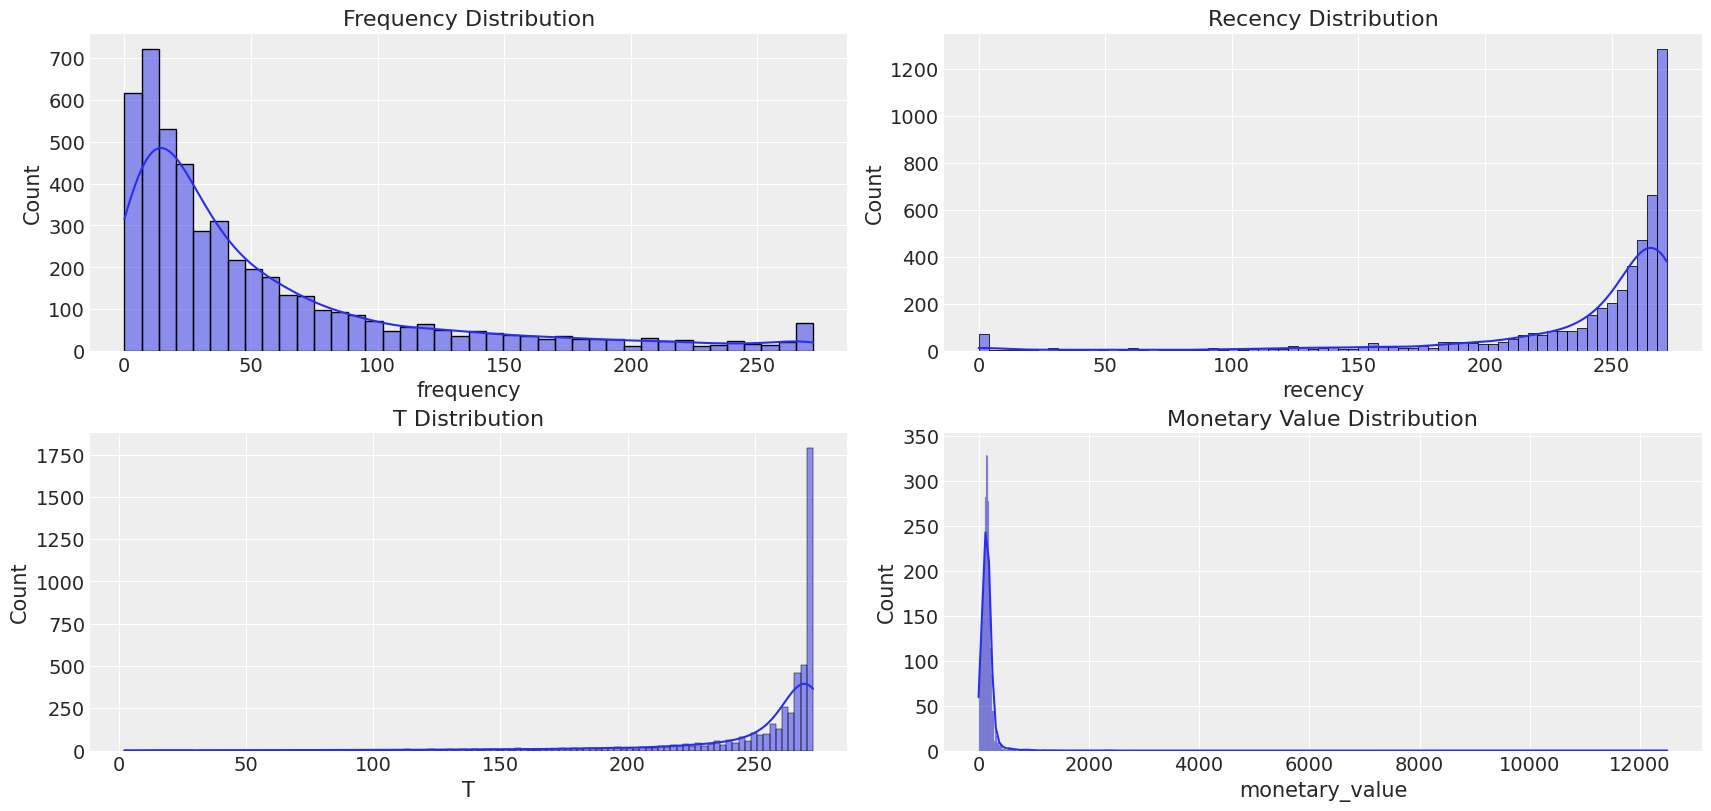

In [102]:
fig, axes = plt.subplots(2, 2, figsize=(17, 8))

# Plot histograms
sns.histplot(train_data["frequency"], kde=True, ax=axes[0, 0])
axes[0, 0].set_title("Frequency Distribution")

sns.histplot(train_data["recency"], kde=True, ax=axes[0, 1])
axes[0, 1].set_title("Recency Distribution")

sns.histplot(train_data["T"], kde=True, ax=axes[1, 0])
axes[1, 0].set_title("T Distribution")

sns.histplot(train_data["monetary_value"], kde=True, ax=axes[1, 1])
axes[1, 1].set_title("Monetary Value Distribution")

plt.show();

### Summary Statistics

In [103]:
with pd.option_context("display.float_format", "{:,.2f}".format):
    print(train_data.describe())

       frequency  recency        T  monetary_value
count   4,961.00 4,961.00 4,961.00        4,961.00
mean       55.04   238.52   250.73          161.56
std        62.19    53.91    41.17          249.08
min         0.00     0.00     2.00            0.00
25%        12.00   235.00   251.00           97.32
50%        31.00   260.00   268.00          144.81
75%        71.00   269.00   272.00          185.16
max       272.00   272.00   273.00       12,493.76


### Correlation Heatmap

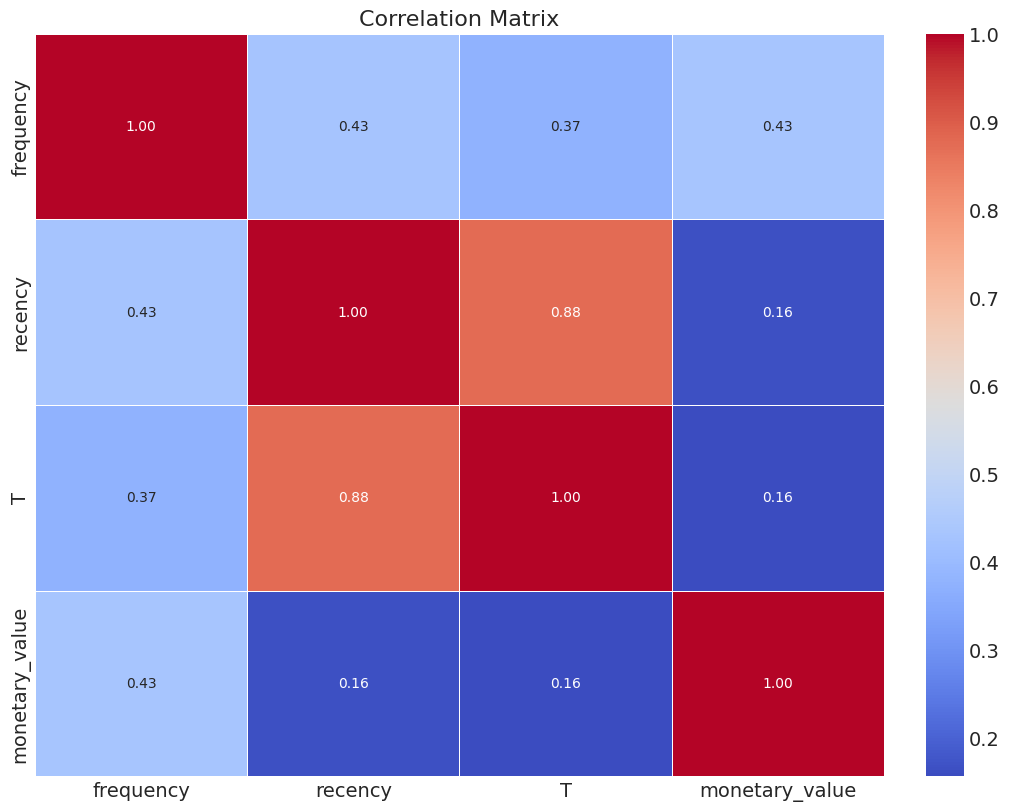

In [104]:
correlation_matrix = train_data[["frequency", "recency", "T", "monetary_value"]].corr(
    method="pearson"
)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, ax=ax
)
plt.title("Correlation Matrix")
plt.show();

## Bull-Till-You-Die (BTYD) Model

The Pareto/NBD model is based on the following assumptions for each customer:

1. Customers are active for an unobserved period of time, then become permanently inactive.

### Purchasing Process

2. While active, the the number of transactions made by a customer follows a Poisson process with transaction rate $\lambda$ :

    $$
    P(X(t)=x \mid \lambda)=\frac{(\lambda t)^x e^{-\lambda t}}{x!}, x=0,1,2, \ldots
    $$


    This is equivalent to assuming time between transactions is exponentially distributed with transaction rate $\lambda$:

    $$
    f\left(t_j-t_{j-1} \mid \lambda\right)=\lambda e^{-\lambda\left(t_j-t_{j-1}\right)}, \quad t_j \geq t_{j-1} \geq 0
    $$

    Where $t$ is the time period of the $j$ th purchase.

3. Heterogeneity in $\lambda$ follows a Gamma distribution with shape parameter $r$ and rate parameter $\alpha$ :

    $$
    g(\lambda \mid r, \alpha)=\frac{\alpha^r \lambda^{r-1} e^{-\lambda \alpha}}{\Gamma(r)}
    $$

### Dropout Process

4. The duration of a customer's unobserved active lifetime is exponentially distributed with dropout rate $\mu$.

5. Heterogeneity in $\mu$ also follows a Gamma distribution with shape parameter $s$ and rate parameter $\beta$ :

    $$
    g(\mu \mid s, \beta)=\frac{\beta^s \mu^{s-1} e^{-\mu \beta}}{\Gamma(s)}
    $$

6. Transaction rate $\lambda$ and time until dropout $\mu$ vary independently for each customer.

If we take the expectation across the distributions of $\lambda$ and $\mu$, we can derive a likelihood function to estimate parameters $r, \alpha, s$, and $\beta$ across the customer population. For more details on the ParetoNBD likelihood please refer to the docs.

### Prior Specifications

Below is practical workflow to **use the data itself** (frequency, recency, T) to **inform the hyperparameters (i.e. the shape/rate)** of our Pareto/NBD priors. This approach— sometimes called *empirical Bayes* or a *moment-matching* strategy— helps ensure the priors start in a “reasonable” region of parameter space rather than being purely guesswork.

#### Using Frequentist Estimates

1. **Fit a frequentist Pareto/NBD** model with `lifetimes.ParetoNBDFitter` to the RFM data:

   - `frequency`: total number of repeat purchases for each customer  
   - `recency`: time between first purchase and last purchase  
   - `T`: time from first purchase until end of observation window  

2. **Extract the MLE parameters** $(r, \alpha, s, \beta)$ from `pnbd_lt.params_`, which is an `OrderedDict`:

   - $\lambda \sim \Gamma(r, \alpha)$ for purchase behavior (with $\alpha$ as **rate**)
   - $\mu \sim \Gamma(s, \beta)$ for dropout behavior (with $\beta$ as **rate**)

3. **Map MLE estimates into Bayesian priors**: In `pymc_marketing`, a typical parameterization for `Prior("Gamma", alpha=?, beta=?)` expects `alpha=?` as the **shape** and `beta=?` as the **rate**.  
   - We can directly set `r_prior = Prior("Gamma", alpha=r_mle, beta=alpha_mle)` and `s_prior = Prior("Gamma", alpha=s_mle, beta=beta_mle)` to reflect the MLE shape and rate.  
   - We can also use the MLE rates parameters for the rates parameters of `alpha_prior` and `beta_prior`, or keep simpler “fallback” defaults like `Gamma(2.0, 0.2)` if we want to allow more prior uncertainty.

With this approach, the Bayesian model starts near the frequentist MLE solution, which often stabilizes inference and improves predictive performance—particularly on smaller datasets or when data is not overly abundant.

In [186]:
model_config_mle_btyd: Dict[str, Prior] = create_btyd_model_config_mle(
    rfm_data=train_data,
    use_mle_for_alpha_beta=False,
)

model_config_mle_btyd

{'r_prior': Prior("Gamma", alpha=0.9994459204042974, beta=4.8290793310785824),
 'alpha_prior': Prior("Gamma", alpha=2.0, beta=0.2),
 's_prior': Prior("Gamma", alpha=2.373684806241492e-09, beta=269.1410153020359),
 'beta_prior': Prior("Gamma", alpha=2.0, beta=0.2)}

### Maximum Likelihood Estimates (MLE)

For a Gamma distribution that uses a rate parameterization, the mean is given by:

$$
\text{Mean} = \frac{\text{shape}}{\text{rate}} = \text{shape} \times \text{scale}
$$

So, the MLEs for $\lambda$ and $\mu$ based on the priors would be their expected values (means):

1. **Expected Transaction Rate ($\mathbb{E}[\lambda]$)**:
   $$
   \mathbb{E}[\lambda] = \frac{r \sim \Gamma(\text{r prior shape}, \text{r prior rate})}{\alpha \sim \Gamma(\alpha \; \text{prior shape}, \alpha \; \text{prior rate})}
   $$

2. **Expected Dropout Rate ($\mathbb{E}[\mu]$)**:
   $$
   \mathbb{E}[\mu] = \frac{s \sim \Gamma(\text{s prior shape}, \text{s prior rate})}{\beta \sim \Gamma(\beta \; \text{prior shape}, \beta \; \text{prior rate})}
   $$

In [187]:
# Gamma parameters for the lambda prior
alpha_r_prior: float = model_config_mle_btyd["r_prior"].parameters["alpha"]
beta_r_prior: float = model_config_mle_btyd["r_prior"].parameters["beta"]

alpha_alpha_prior: float = model_config_mle_btyd["alpha_prior"].parameters["alpha"]
beta_alpha_prior: float = model_config_mle_btyd["alpha_prior"].parameters["beta"]

# Gamma parameters for the mu prior
alpha_s_prior: float = model_config_mle_btyd["s_prior"].parameters["alpha"]
beta_s_prior: float = model_config_mle_btyd["s_prior"].parameters["beta"]

alpha_beta_prior: float = model_config_mle_btyd["beta_prior"].parameters["alpha"]
beta_beta_prior: float = model_config_mle_btyd["beta_prior"].parameters["beta"]

In [188]:
expected_r: float = alpha_r_prior / beta_r_prior
expected_alpha: float = alpha_alpha_prior / beta_alpha_prior

expected_s: float = alpha_s_prior / beta_s_prior
expected_beta: float = alpha_beta_prior / beta_beta_prior

expected_lambda: float = expected_r / expected_alpha
expected_mu: float = expected_s / expected_beta

print(f"Expected Lambda: {expected_lambda:.2f} per time unit")
print(f"Expected Mu: {expected_mu} per time unit")

Expected Lambda: 0.02 per time unit
Expected Mu: 8.819483732636184e-13 per time unit


1. **Expected Lambda (Transaction Rate):**  The result
   $$
   \mathbb{E}[\lambda] = 0.02 \quad \text{per time unit}
   $$
   implies that, on average, an active customer makes 0.02 transactions in one time unit. In practical terms, given our time unit in days, this set of priors encode the understanding that an active account is expected to transact about once every $\frac{1}{0.02} = 50$ days.

2. **Expected Mu (Dropout Rate):** The result
   $$
   \mathbb{E}[\mu] \approx 8.82 \times 10^{-13} \quad \text{per time unit}
   $$
   is extraordinarily small. In the Pareto/NBD model, $\mu$ represents the rate at which accounts drop out (or become inactive). An extremely small $\mu$ implies that once an account is active, the chance they become inactive in any given time unit is nearly zero. 

    > Note that this is a characteristic of the transactional data at hand and is not be generalizable to other datasets beyond this domain. For instance, subscriptions businesses may have higher dropout rates. 

### Predictive Checks

#### Bayes Theorem

Bayes' theorem provides us with a general recipe to estimate the value of the parameters $\boldsymbol{\theta}$ given that we have observed some data $\boldsymbol{Y}$:

$$
\underbrace{p(\boldsymbol{\theta} \mid \boldsymbol{Y})}_{\text {posterior }}=\frac{\overbrace{p(\boldsymbol{Y} \mid \boldsymbol{\theta})}^{\text {likelihood }} \overbrace{p(\boldsymbol{\theta})}^{\text {prior }}}{\underbrace{p(\boldsymbol{Y})}_{\text {marginal likelihood }}}
$$


The likelihood function links the observed data with the unknown parameters while the prior distribution represents the uncertainty about the parameters before observing the data $\boldsymbol{Y}$. By multiplying them we obtain the posterior distribution, that is the joint distribution over all the parameters in the model (conditioned on the observed data).

#### Prior

The prior predictive distribution:

$$
p\left(\boldsymbol{Y}^*\right)=\int_{\boldsymbol{\Theta}} p\left(\boldsymbol{Y}^* \mid \boldsymbol{\theta}\right) p(\boldsymbol{\theta}) d \boldsymbol{\theta}
$$


This is the expected distribution of the data according to the model (prior and likelihood). That is the data we expect, given the model, before actually seeing any observed data $Y^*$.

#### Posterior

The posterior predictive distribution:

$$
p(\tilde{\boldsymbol{Y}} \mid \boldsymbol{Y})=\int_{\boldsymbol{\Theta}} p(\tilde{\boldsymbol{Y}} \mid \boldsymbol{\theta}) p(\boldsymbol{\theta} \mid \boldsymbol{Y}) d \boldsymbol{\theta}
$$


This is the distribution of expected, future, data $\tilde{\boldsymbol{Y}}$ according to the posterior $p(\boldsymbol{\theta} \mid \boldsymbol{Y})$, which in turn is a consequence of the model (prior and likelihood) and observed data. In more common terms, this is the data the model is expecting to see after seeing the dataset $\boldsymbol{Y}$, i.e. these are the model's predictions. From the equation, we can see that predictions are computed by integrating out (or marginalizing) over the posterior distribution of parameters. As a consequence, predictions computed this way will incorporate the uncertainty regarding the parameters estimations.

In [108]:
max_purchases: int = int(train_data["frequency"].max())
max_purchases

272

Sampling: [alpha, beta, r, recency_frequency, s]
/Users/yang_wu/pyapp/credit_card_clv/.venv/lib/python3.12/site-packages/pymc_marketing/clv/distributions.py:295: RuntimeWarning: divide by zero encountered in scalar divide
  dropout_time = rng.exponential(scale=1 / mu)
/Users/yang_wu/pyapp/credit_card_clv/.venv/lib/python3.12/site-packages/pymc_marketing/clv/distributions.py:296: RuntimeWarning: divide by zero encountered in scalar divide
  wait = rng.exponential(scale=1 / lam)
/Users/yang_wu/pyapp/credit_card_clv/.venv/lib/python3.12/site-packages/pymc_marketing/clv/distributions.py:296: RuntimeWarning: overflow encountered in scalar divide
  wait = rng.exponential(scale=1 / lam)
Multiprocess sampling (4 chains in 4 jobs)
DEMetropolisZ: [alpha, beta, r, s]


Output()

/Users/yang_wu/pyapp/credit_card_clv/.venv/lib/python3.12/site-packages/pymc/step_methods/metropolis.py:1194: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),


/Users/yang_wu/pyapp/credit_card_clv/.venv/lib/python3.12/site-packages/pymc/step_methods/metropolis.py:1194: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/Users/yang_wu/pyapp/credit_card_clv/.venv/lib/python3.12/site-packages/pymc/step_methods/metropolis.py:1194: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/Users/yang_wu/pyapp/credit_card_clv/.venv/lib/python3.12/site-packages/pymc/step_methods/metropolis.py:1194: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),


Sampling 4 chains for 5_800 tune and 5_300 draw iterations (23_200 + 21_200 draws total) took 13 seconds.
Sampling: [recency_frequency]


Output()

/Users/yang_wu/pyapp/credit_card_clv/.venv/lib/python3.12/site-packages/pymc_marketing/clv/distributions.py:295: 
RuntimeWarning: divide by zero encountered in scalar divide
  dropout_time = rng.exponential(scale=1 / mu)

/Users/yang_wu/pyapp/credit_card_clv/.venv/lib/python3.12/site-packages/pymc_marketing/clv/distributions.py:295: 
RuntimeWarning: overflow encountered in scalar divide
  dropout_time = rng.exponential(scale=1 / mu)

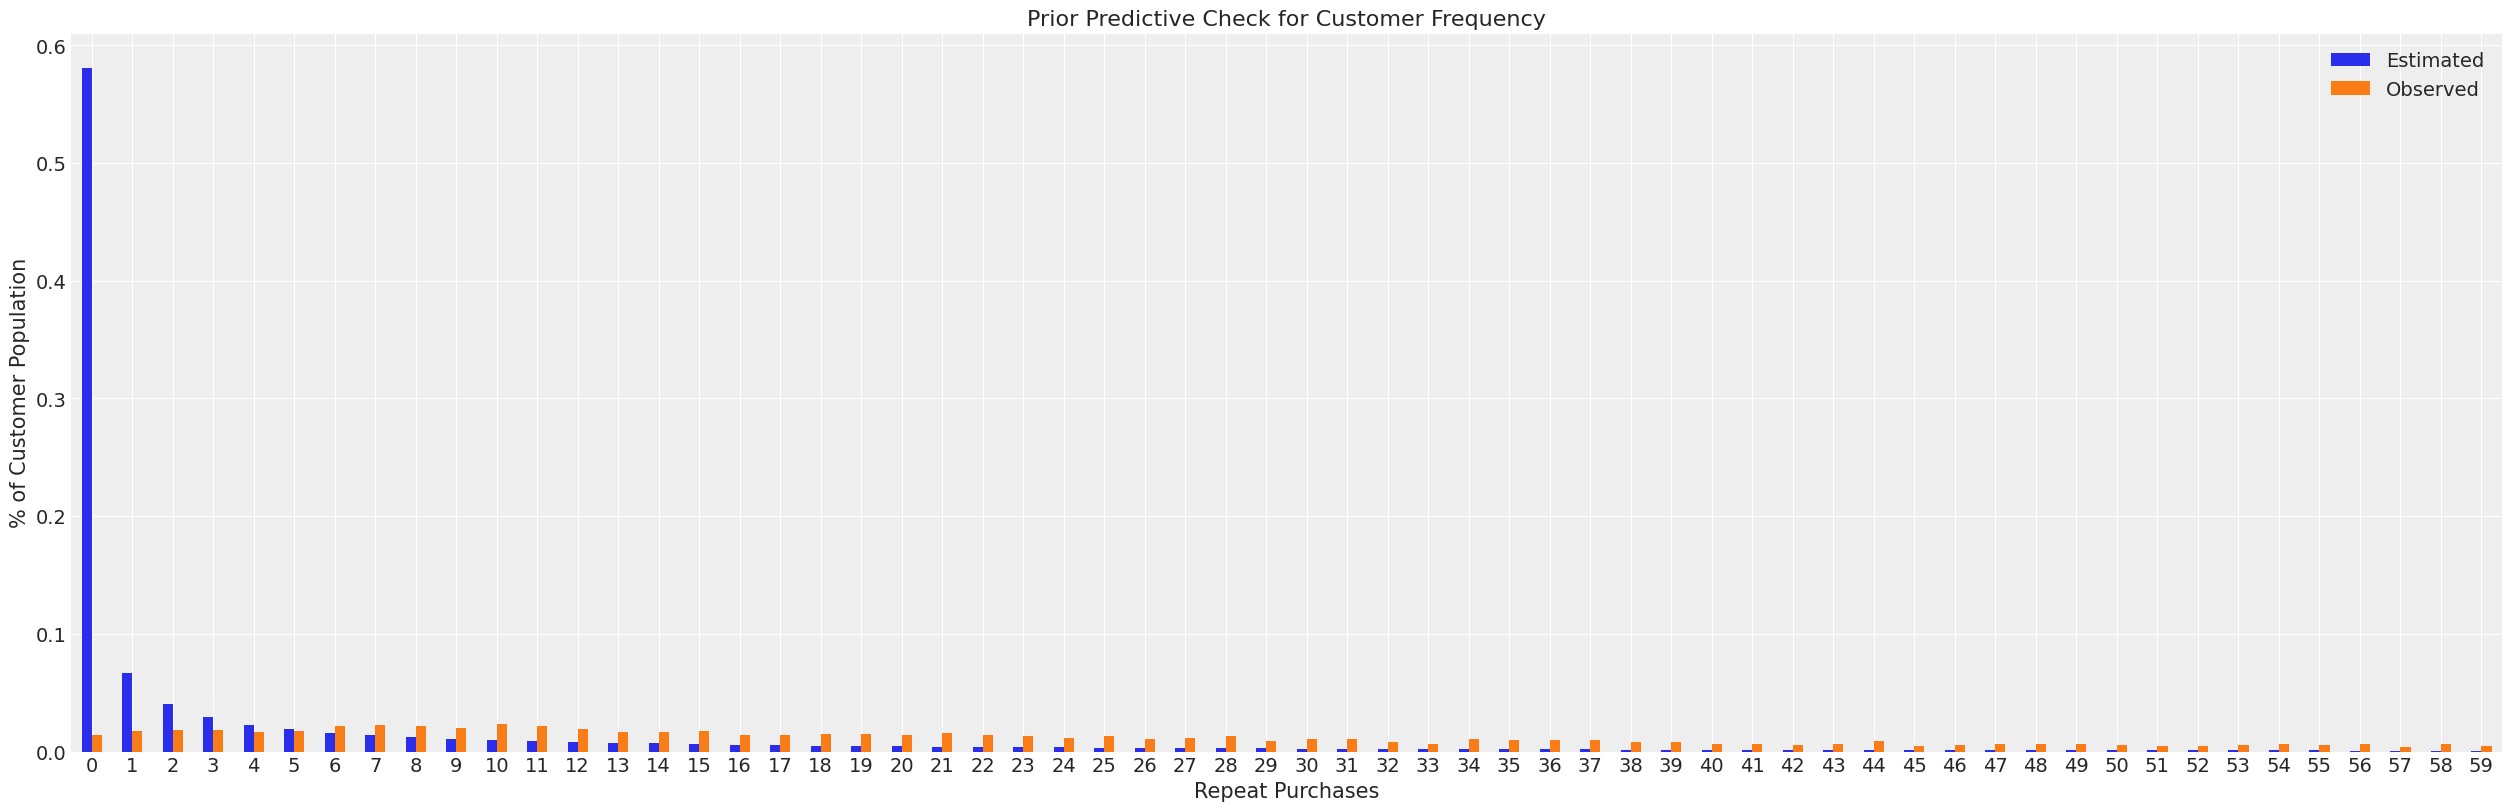

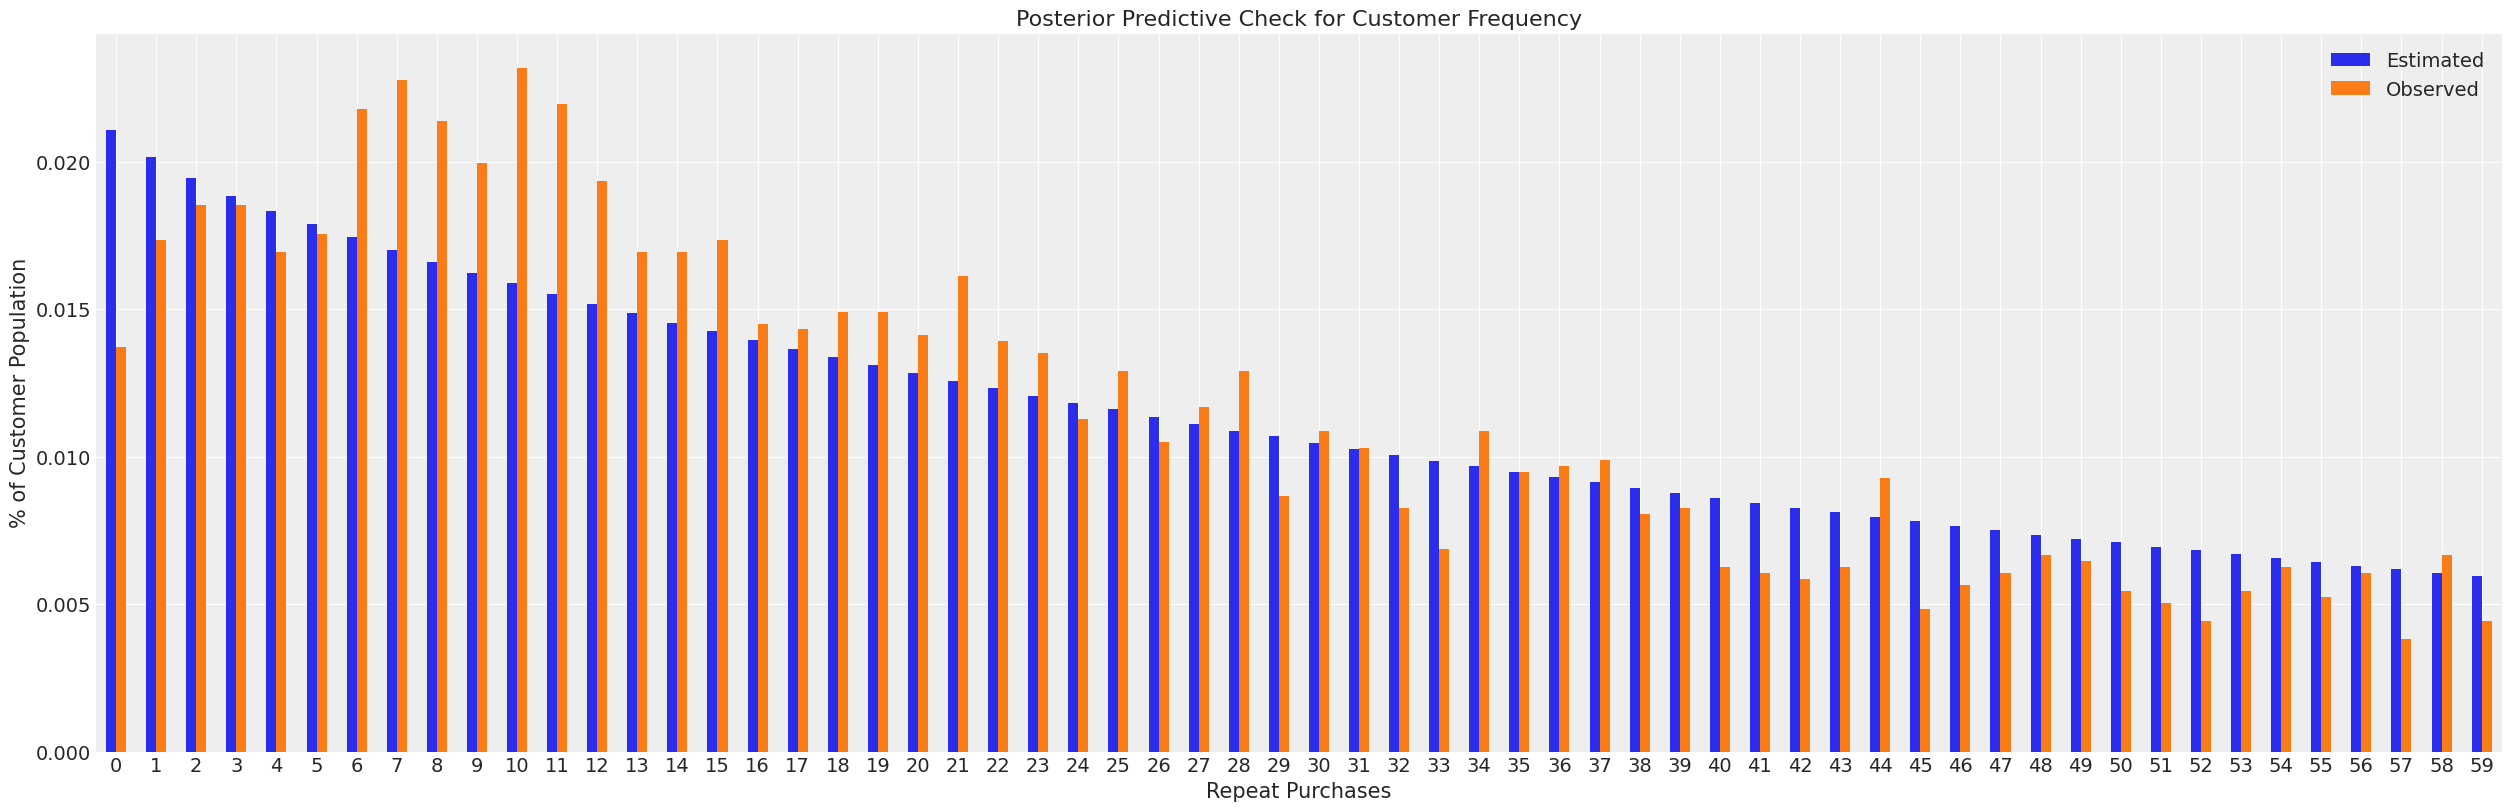

In [109]:
pnbd_model, prior_check, posterior_check = run_pnbd_ppcs(
    rfm_data=train_data.loc[:, ["customer_id", "frequency", "recency", "T"]],
    model_config=model_config_mle_btyd,
    fit_method="demz",
    prior_samples=1000,
    # Compore just up to 60 repeat purchases instead of the maximum
    max_purchases=60,
    random_seed=random_state,
    draws=5300,
    tune=5800,
    fig_size=(25, 8),
    idata_kwargs={"log_likelihood": True},
)

### Model Persistence

Convert the `customer_id` to Unicode strings for compatibility with PyMC3:

In [111]:
for group in pnbd_model.idata.groups():
    print(f"Group: {group}")
    ds = pnbd_model.idata[group]
    for var in ds.data_vars:
        print(f"  Variable: {var}, dtype: {ds[var].dtype}")

pnbd_model.idata.fit_data["customer_id"] = pnbd_model.idata.fit_data[
    "customer_id"
].astype("U")

Group: posterior
  Variable: alpha, dtype: float64
  Variable: beta, dtype: float64
  Variable: r, dtype: float64
  Variable: s, dtype: float64
Group: log_likelihood
  Variable: recency_frequency, dtype: float64
Group: sample_stats
  Variable: lambda, dtype: float64
  Variable: accept, dtype: float64
  Variable: accepted, dtype: bool
  Variable: scaling, dtype: float64
Group: observed_data
  Variable: recency_frequency, dtype: float64
Group: fit_data
  Variable: customer_id, dtype: <U9
  Variable: frequency, dtype: float64
  Variable: recency, dtype: float64
  Variable: T, dtype: float64


Save the full model along with two **thinned** versions. Retain every 20th and 50th draw to reduce memory usage. For $n$ draws, the thinned datasets will contain $\frac{n}{20}$ and $\frac{n}{50}$ draws, respectively.

In [112]:
pnbd_model.save(str(model_path / f"pnbd_model_full.nc"))

for keep_every in [20, 50]:
    thin_model: ParetoNBDModel = pnbd_model.thin_fit_result(keep_every=keep_every)

    thin_model.save(str(model_path / f"pnbd_model_thin_{keep_every}.nc"))

In [113]:
pnbd_model = pnbd_model.thin_fit_result(keep_every=20)

### Diagnostics

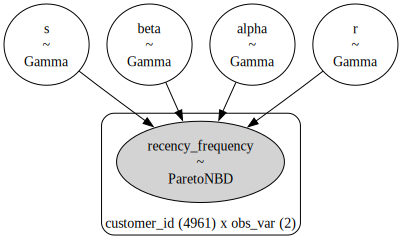

In [114]:
pnbd_model.graphviz()

#### Convergence and Efficiency Diagnostics for Markov Chains

[Source](https://mc-stan.org/rstan/reference/Rhat.html)

- **Mean**  

  - **Definition:** The average value of the posterior samples for a parameter.  
  - **Importance:** Provides a point estimate of the parameter’s central tendency.

- **SD (Standard Deviation)**  

  - **Definition:** Measures the spread or dispersion of the posterior samples around the mean.  
  - **Importance:** Indicates uncertainty in the parameter estimate.

- **HDI (Highest Density Interval) [hdi_3% and hdi_97%]**  

  - **Definition:** The interval within which the parameter value falls with a high probability (here, approximately a 94% interval from the 3rd to the 97th percentile).  
  - **Importance:** Shows the range of credible values for the parameter, helping assess estimation precision.

- **MCSE (Monte Carlo Standard Error) [mcse_mean and mcse_sd]**  

  - **Definition:** The standard error associated with the Monte Carlo estimates of the mean and standard deviation.  
  - **Importance:** Quantifies the sampling variability due to the finite number of draws; low values suggest that the estimates are reliable.

- **ESS (Effective Sample Size) [ess_bulk and ess_tail]**  

  - **Definition:**  

    - **Bulk ESS:** Reflects the effective number of independent samples in the central region of the distribution (affecting estimates like the mean and median).  
    - **Tail ESS:** Reflects the effective number of independent samples in the tails of the distribution (affecting estimates such as quantiles or variance).  
  - **Importance:** High ESS values (a rough rule of thumb is at least 100 per chain) indicate that the sampling was efficient and that the estimates of posterior quantities are reliable.

- **R-hat**  

  - **Definition:** A convergence diagnostic that compares the variance between chains with the variance within chains.  
  - **Importance:** An R-hat value close to 1 (commonly below 1.05) suggests that multiple chains have converged to the same distribution, ensuring reliable posterior inference.


In [115]:
pnbd_model.fit_summary()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,4.825,0.111,4.609,5.025,0.003,0.002,1006.0,943.0,1.0
beta,9.770,7.098,0.589,23.109,0.230,0.163,906.0,1016.0,1.0
r,0.999,0.018,0.965,1.034,0.001,0.000,809.0,819.0,1.0
s,0.000,0.000,0.000,0.000,0.000,0.000,831.0,870.0,1.0


#### Trace Plot

- **Model Object (`pnbd_model`):** The variable `pnbd_model` contains the results of fitting a Pareto/NBD model using Markov Chain Monte Carlo (MCMC) techniques. This object stores posterior samples for the model parameters, which are used for diagnostic purposes and further analysis.

- **MCMC Chains (Y-Axis: Chain 0 to 3):** The plot displays multiple independent chains, labeled 0 through 3. Each chain represents a separate sequence of samples generated during the MCMC simulation. Independent chains are used to ensure that the sampling process converges to the same target distribution regardless of the starting values. Consistency across these chains is an indication that the sampling process is robust and the model is converging well.

- **Rank Bars (X-Axis: Rank 0 to 1000):** In this visualization, the "rank" of a sample refers to its position in an ordered list when the samples from a single chain are sorted by their value. The x-axis shows these ranks, which in this case range from 0 to 1000, representing the positions of approximately 1000 samples per chain.
  
  - **Even Ranks:** When the rank bars appear even and uniformly distributed across the range, it suggests that the samples from the chain are well mixed. This uniformity indicates that the chain has adequately explored the parameter space, and that the distribution of samples is smooth. In essence, evenly spaced rank bars are an indicator of successful convergence and reliable sampling.

  - **Uneven Ranks:** If the rank bars show irregularities or clustering (i.e., uneven distribution), it could signal issues with mixing within the chain. An uneven rank distribution might reveal that the chain is stuck in certain regions of the parameter space or has not fully converged to the target distribution. Such behavior may necessitate additional diagnostic checks or adjustments to the sampling process (e.g., increasing the number of iterations, adjusting tuning parameters, or reconsidering the model specification).

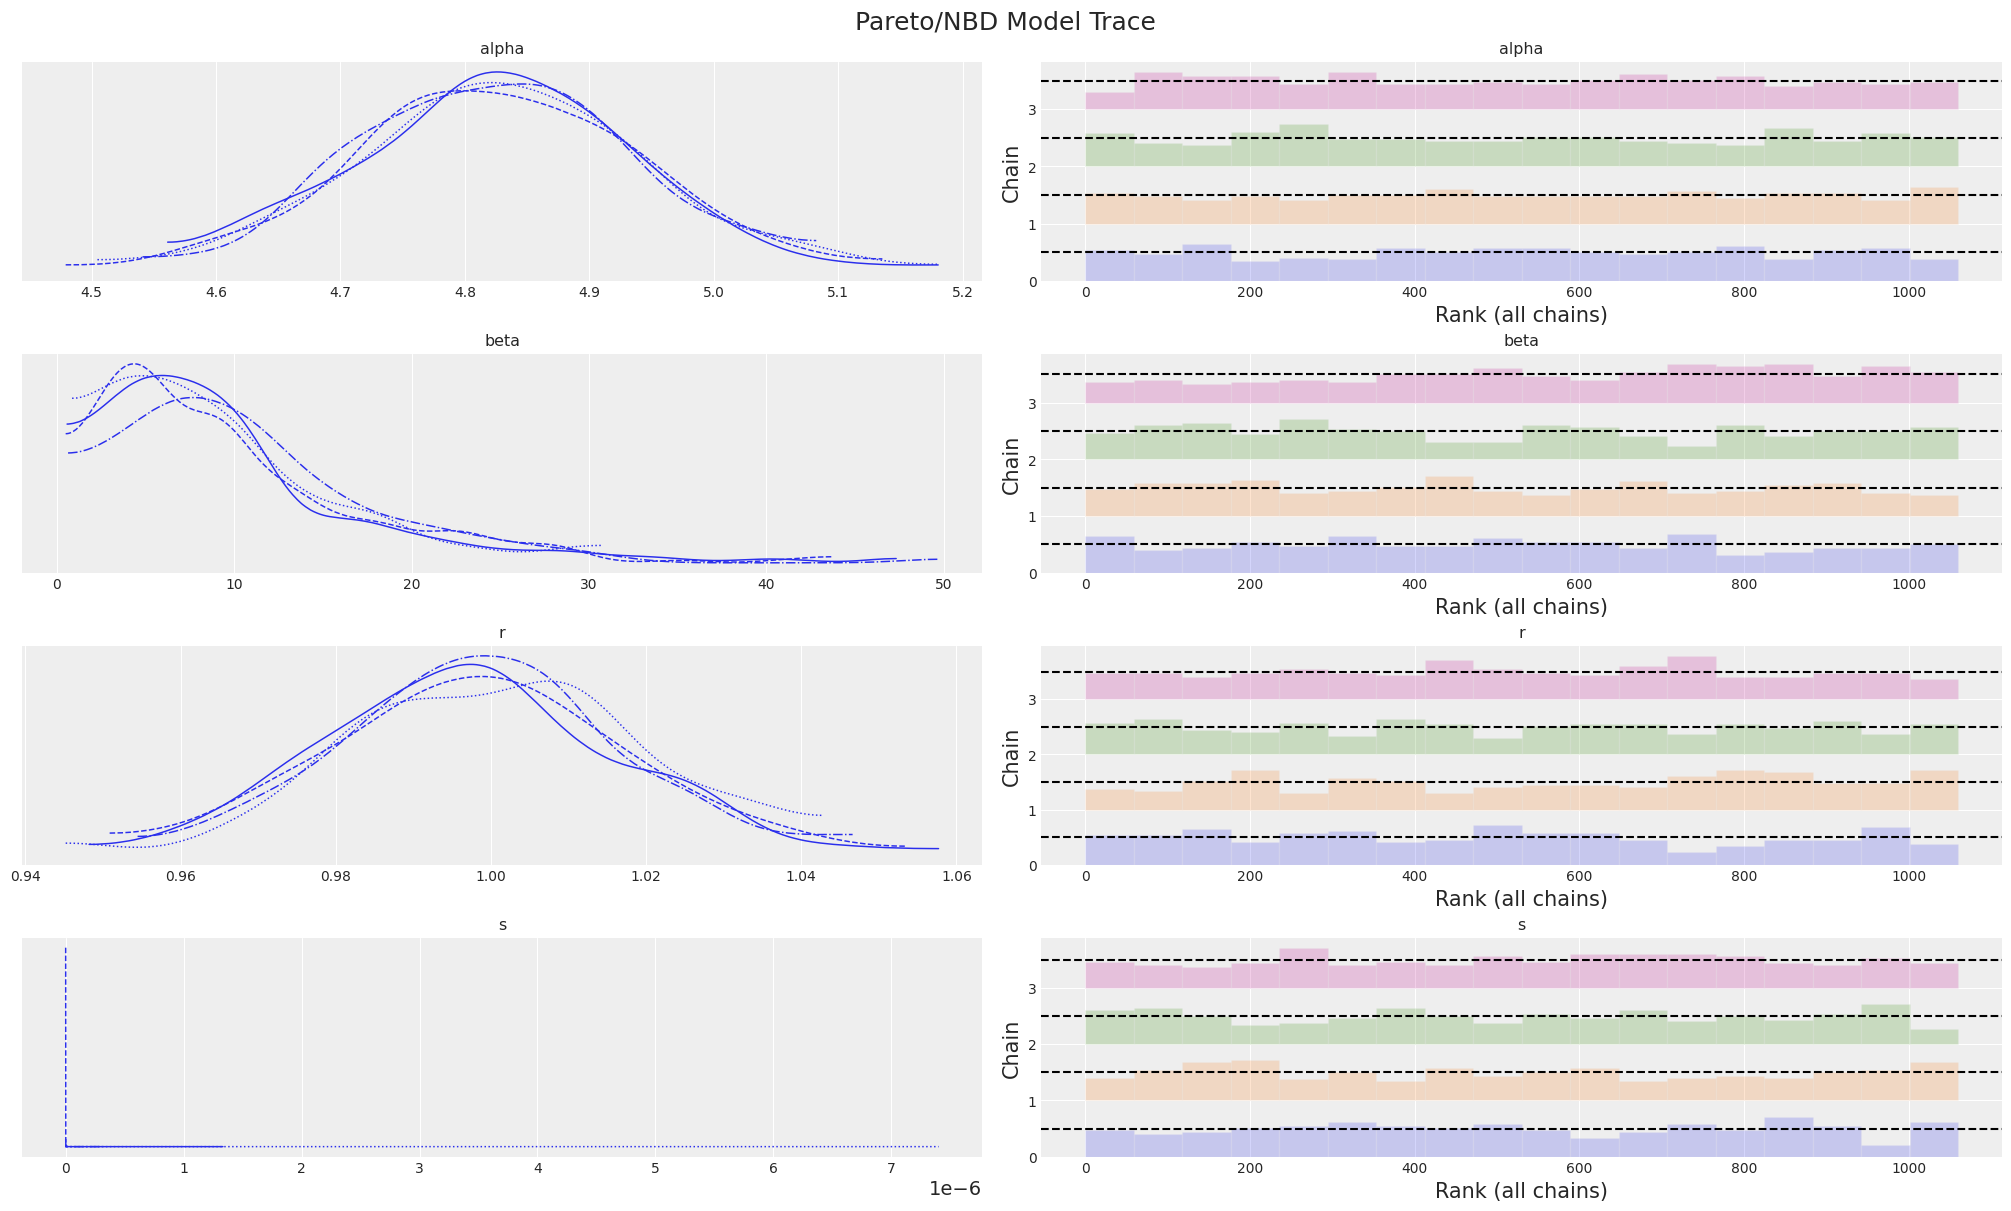

In [210]:
axes = az.plot_trace(
    data=pnbd_model.idata,
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (20, 12), "layout": "constrained"},
)
plt.gcf().suptitle(
    "Pareto/NBD Model Trace",
    fontsize=18,
);

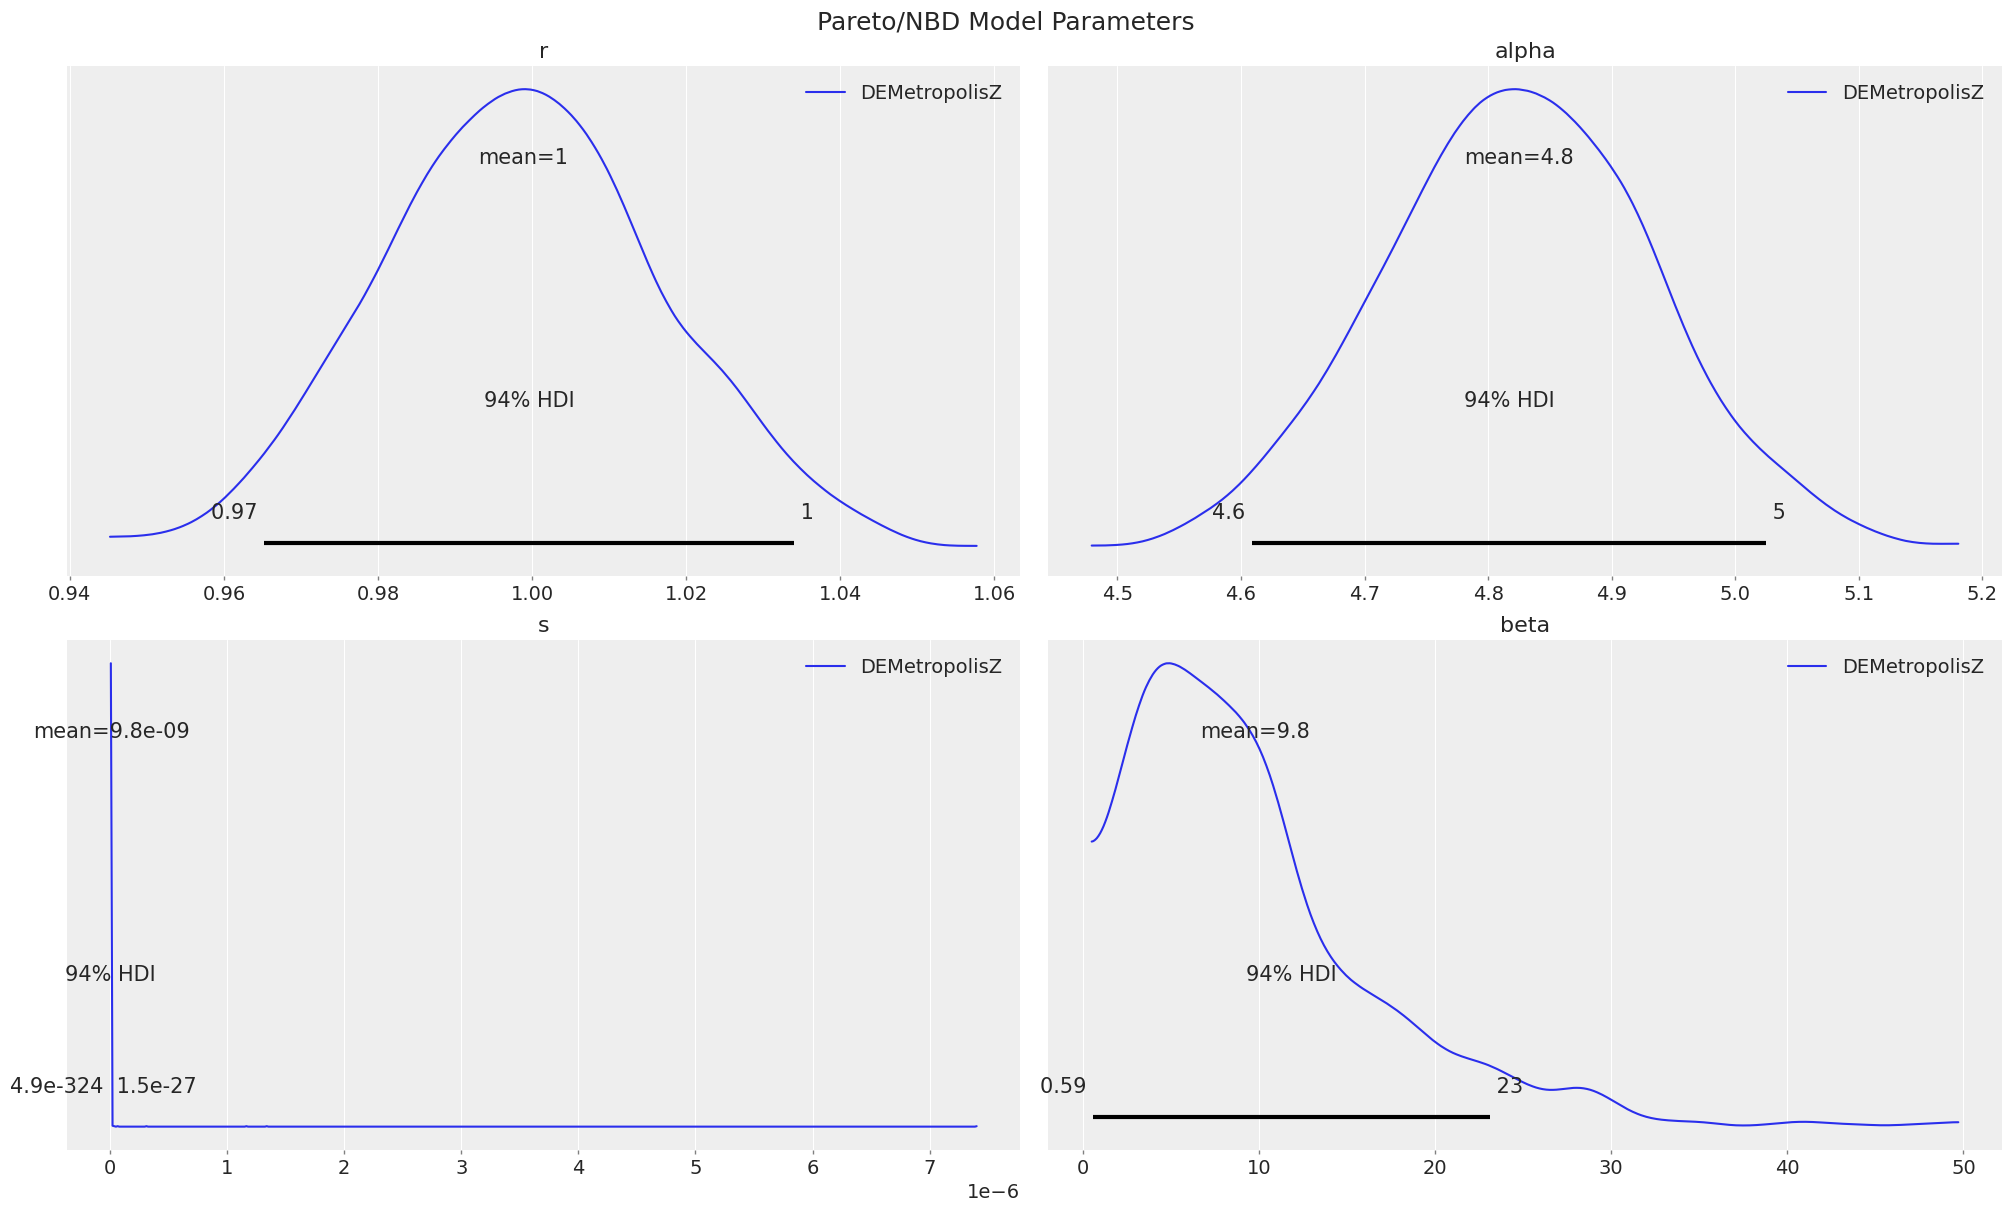

In [209]:
_, axes = plt.subplots(
    nrows=2, ncols=2, figsize=(20, 12), sharex=False, sharey=False, layout="constrained"
)
axes = axes.flatten()

for i, var_name in enumerate(["r", "alpha", "s", "beta"]):
    ax = axes[i]
    az.plot_posterior(
        pnbd_model.idata.posterior[var_name].values.flatten(),
        color="C0",
        point_estimate="mean",
        ax=ax,
        label="DEMetropolisZ",
    )
    ax.legend(loc="upper right")
    ax.set_title(var_name)

plt.gcf().suptitle(
    "Pareto/NBD Model Parameters",
    fontsize=18,
);

### Expected Transactions Over Time

#### Validation Period

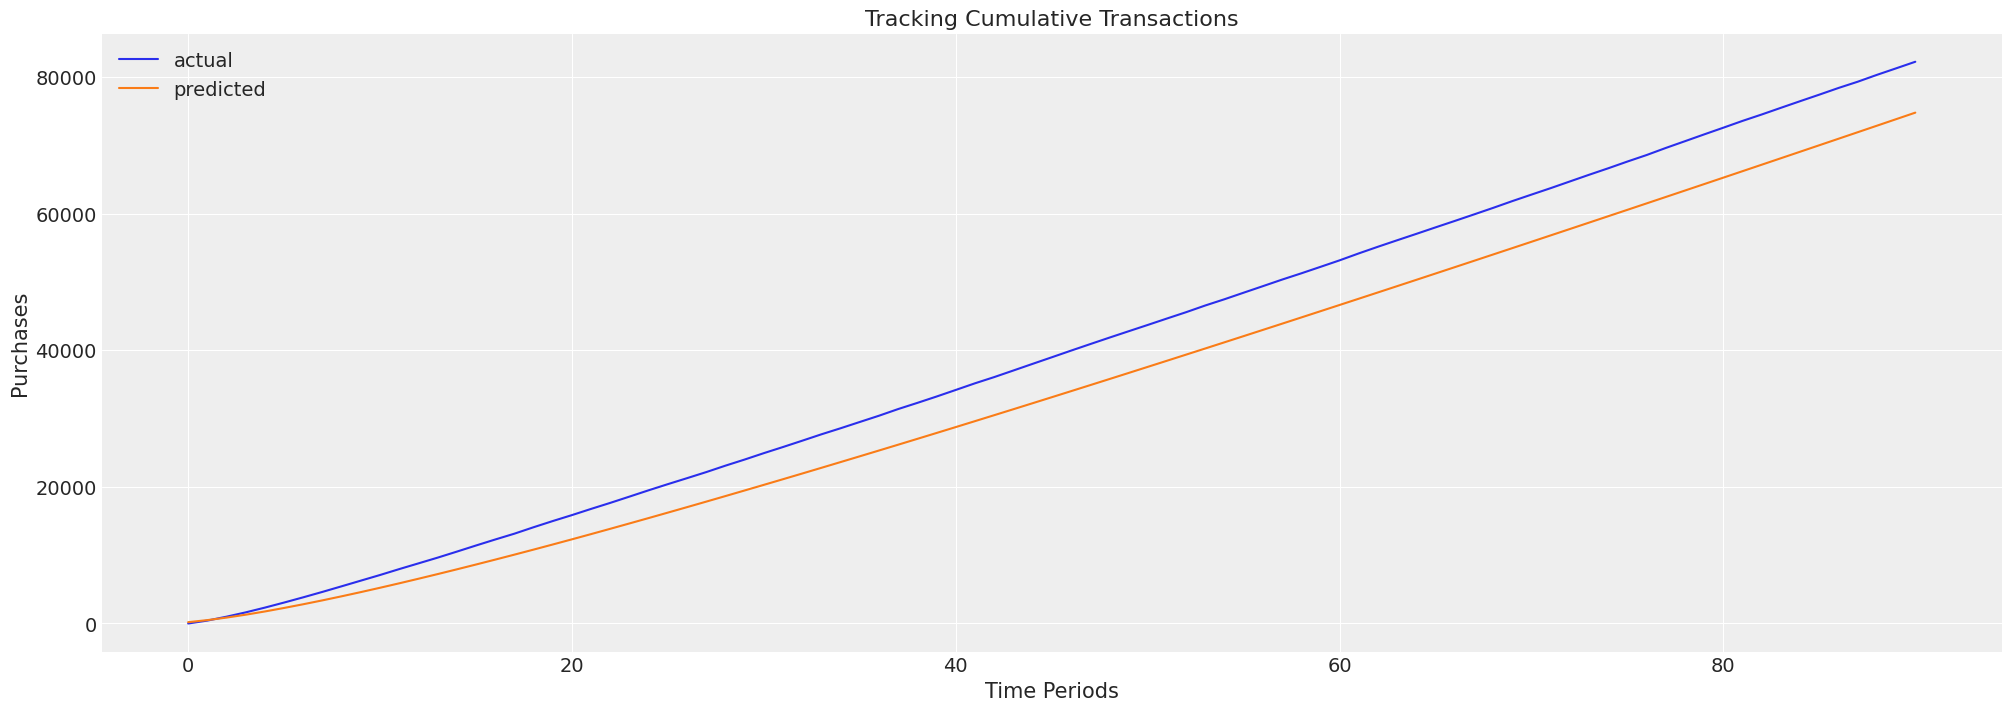

In [118]:
future_t_val: int = (
    pd.to_datetime(validation_period_end) - pd.to_datetime(train_period_end)
).days

plot_expected_purchases_over_time(
    model=pnbd_model,
    purchase_history=data.loc[data["transaction_datetime"] <= train_period_end],
    customer_id_col="account_number",
    datetime_col="transaction_datetime",
    time_unit="D",
    t=future_t_val,
    figsize=(20, 7),
)
plt.show();

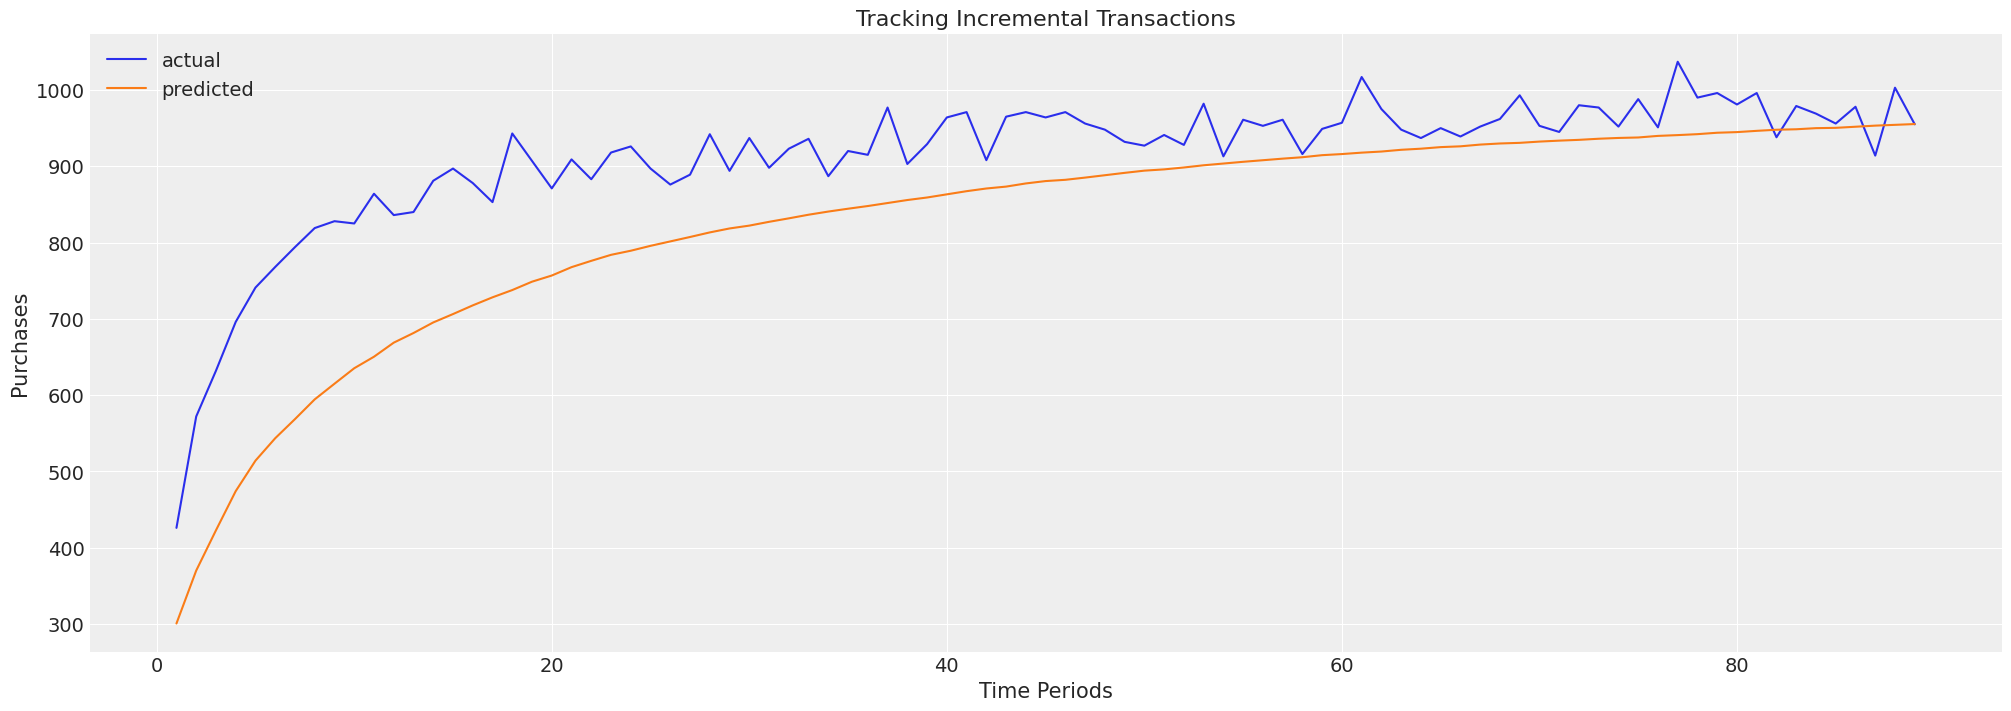

In [119]:
plot_expected_purchases_over_time(
    model=pnbd_model,
    purchase_history=data,
    customer_id_col="account_number",
    datetime_col="transaction_datetime",
    time_unit="D",
    t=90,
    figsize=(20, 7),
    plot_cumulative=False,
)
plt.show();

### Expected Number of Future Purchases 

#### Validation Period

In [363]:
expected_purchases_val: DataArray = pnbd_model.expected_purchases(future_t=future_t_val)

validation_data["expected_purchases"] = expected_purchases_val.mean(
    dim=("chain", "draw")
).values

In [364]:
validation_data

,customer_id,test_frequency,test_T,test_monetary_value,expected_purchases
0,100088067,19.0,91.0,105.290001,16.028833
1,100108752,6.0,91.0,48.928333,7.239457
2,100328049,25.0,91.0,91.034004,20.420838
3,100663626,11.0,91.0,347.093628,6.161539
4,100737756,31.0,91.0,233.735168,32.472720
...,...,...,...,...,...
4956,999086814,76.0,91.0,360.098022,72.059412
4957,999257059,27.0,91.0,211.469635,32.687243
4958,999258704,23.0,91.0,85.534782,17.422175
4959,999283629,25.0,91.0,175.818802,29.806160


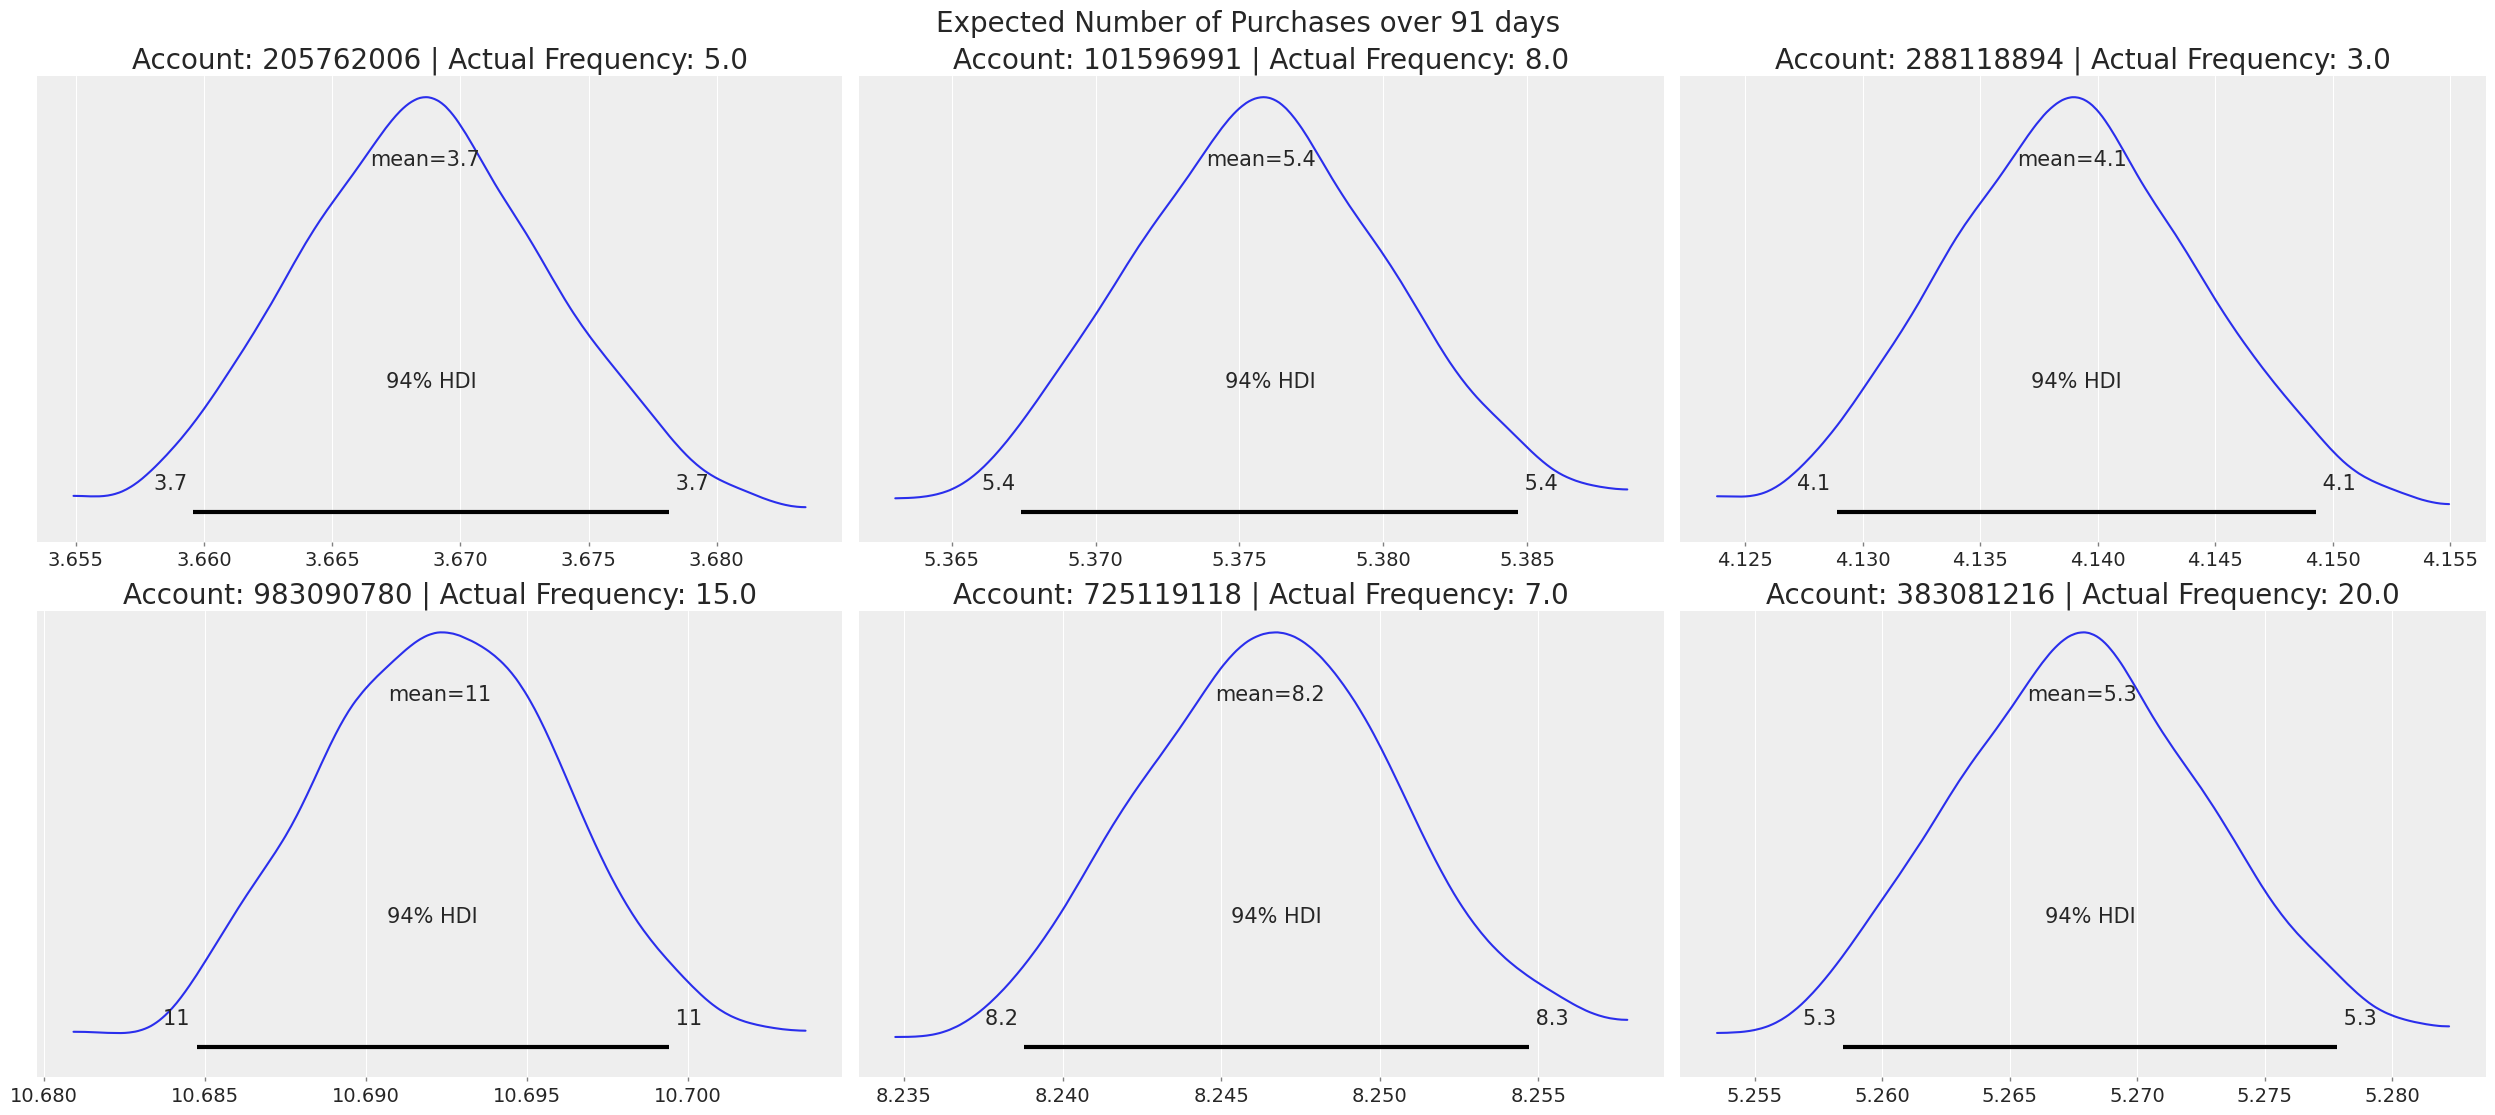

In [122]:
accounts: np.ndarray = rng.choice(
    validation_data["customer_id"].values, size=6, replace=False
)

ax = az.plot_posterior(expected_purchases_val.sel(customer_id=accounts), grid=(2, 3))

for axi, id in zip(ax.ravel(), accounts, strict=False):
    # Get the actual frequency for this customer_id
    actual_frequency = validation_data.loc[
        validation_data["customer_id"] == id, "test_frequency"
    ].values[0]
    # Set the title to include both expected purchases and the actual frequency observed during the validation period
    axi.set_title(f"Account: {id} | Actual Frequency: {actual_frequency}", size=20)

plt.suptitle(f"Expected Number of Purchases over {future_t_val} days", size=20);

In [123]:
validation_rmse: float = root_mean_squared_error(
    y_true=validation_data["test_frequency"],
    y_pred=validation_data["expected_purchases"],
)
validation_mae: float = mean_absolute_error(
    y_true=validation_data["test_frequency"],
    y_pred=validation_data["expected_purchases"],
)

print(f"Validation RMSE: {validation_rmse:.2f}")
print(f"Validation MAE: {validation_mae:.2f}")

Validation RMSE: 4.58
Validation MAE: 3.43


### Expected Number of Transactions For Any Specific Account

The two methods predict expected future purchases but for very different types of customers:

1. `expected_purchases` (Conditional on Customer History):

   - **Purpose:** This method predicts the expected number of future purchases for *existing* customers based on their past behavior. In other words, it is conditional on each customer’s observed history (their **frequency**, **recency**, and **T** — the total time observed).
     
   - **How It Works:**  

     - The method extracts the customer’s past data (frequency, recency, and T) along with any covariate information.

     - It then uses the fitted model parameters $(r, \alpha, s, \beta)$ and computes a log-likelihood (via the `_logp` helper) that reflects how well the parameters explain the observed history.

     - The prediction is computed using several terms (named `first_term`, `second_term`, and `third_term`) that involve gamma functions, logarithms, and exponentials.These terms come from the mathematical derivations (e.g., Equation (41) in Hardie’s notes) that adjust the prediction based on the customer’s transaction history.

     - Finally, the expected number of future purchases is obtained by exponentiating the sum of these terms and adjusting by the computed log-likelihood.
     
   - **Key Point:** Since it uses individual-specific data, the prediction is *conditional* on what the customer has already done. Customers with a long history of purchases (or a high frequency) will receive a different prediction than those with little or no history.

  0%|          | 0/91 [00:00<?, ?it/s]/Users/yang_wu/pyapp/credit_card_clv/.venv/lib/python3.12/site-packages/xarray/core/computation.py:824: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
100%|██████████| 91/91 [02:48<00:00,  1.85s/it]


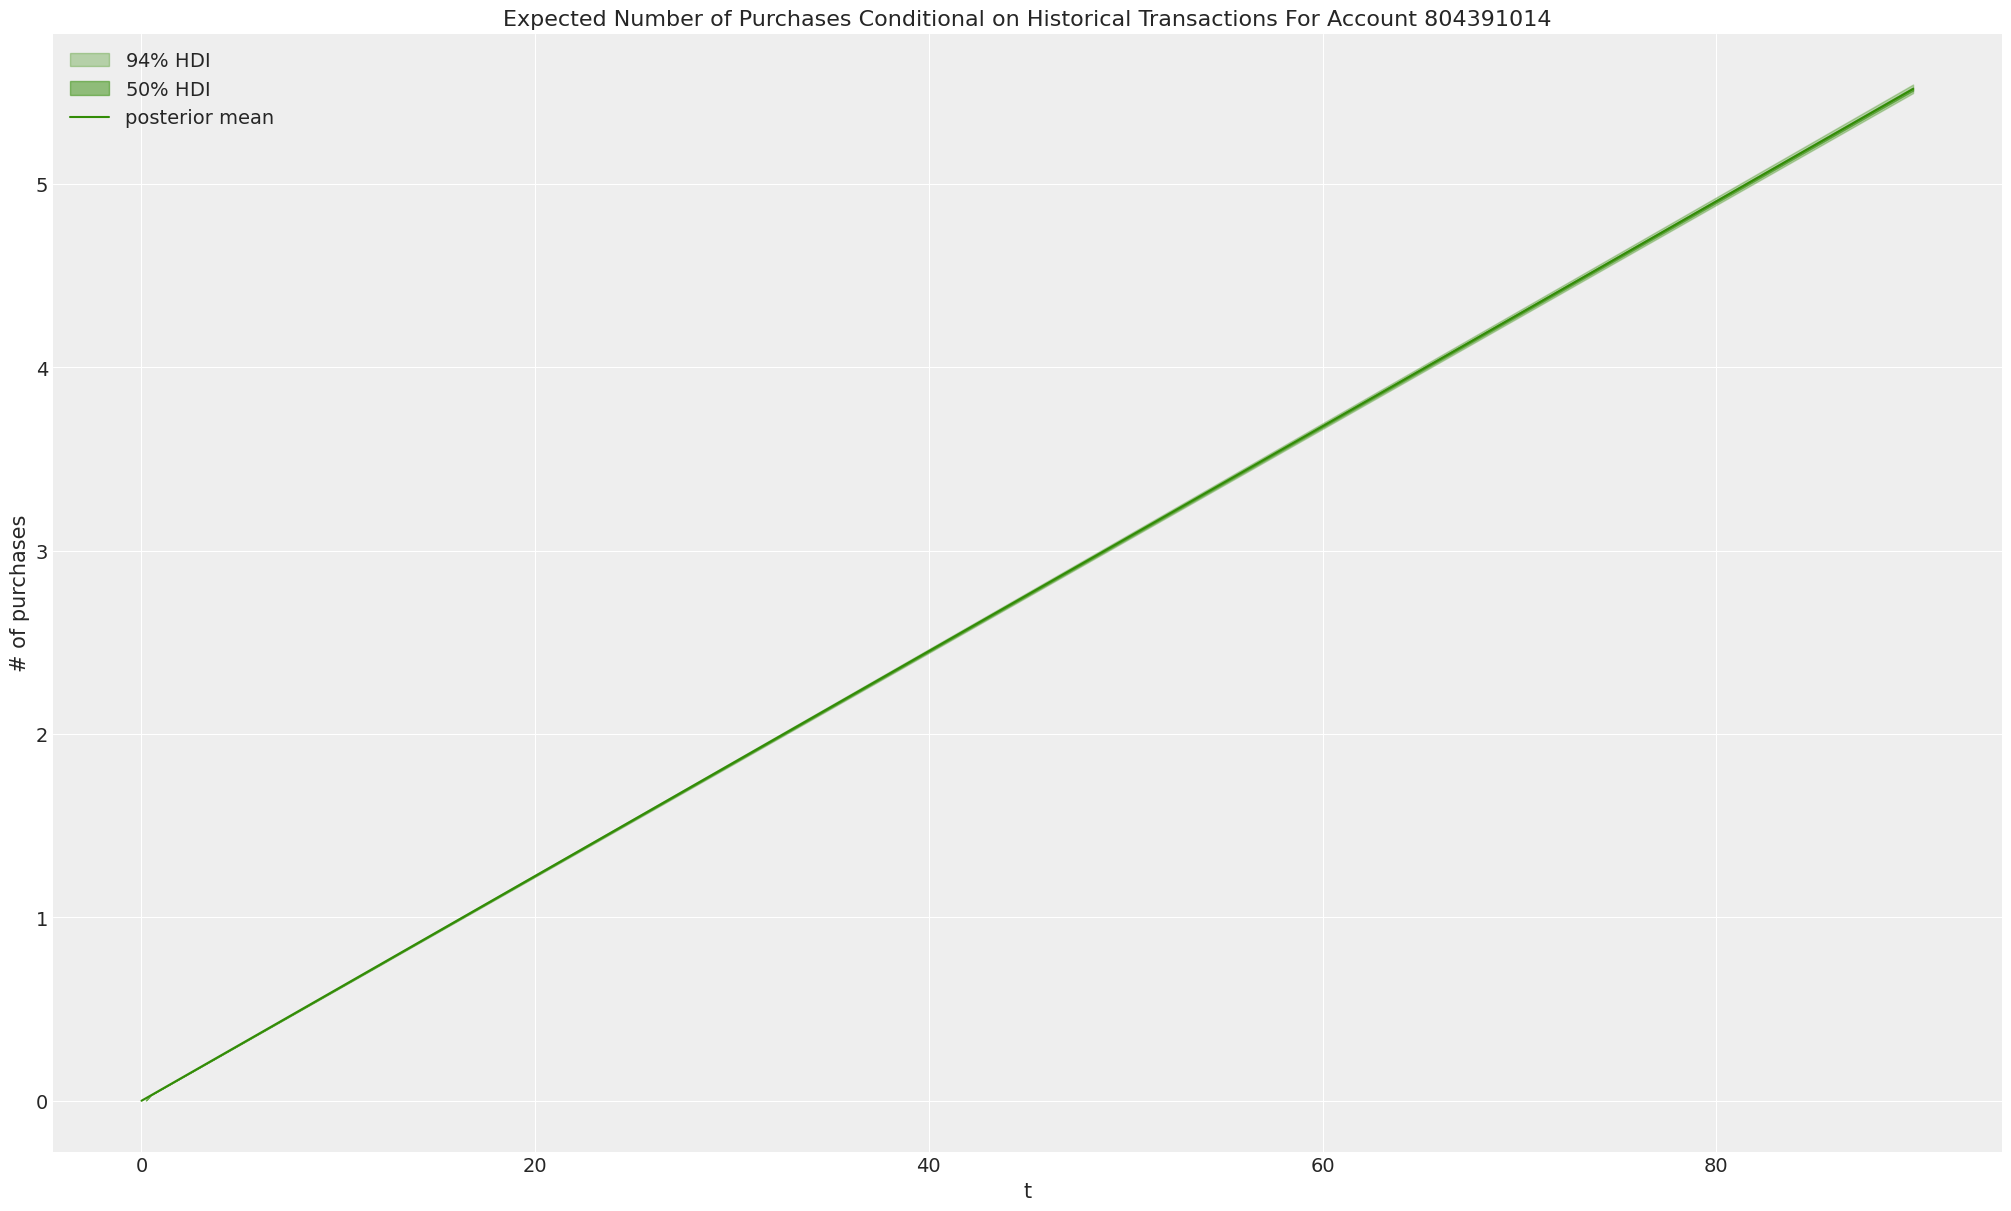

In [124]:
account_id: int = rng.choice(
    validation_data["customer_id"].values, size=1, replace=False
)[0]
t_range: range = range(future_t_val)

expected_purchases_conditional: DataArray = concat(
    objs=[
        pnbd_model.expected_purchases(
            data=train_data,
            future_t=t,
        ).sel(customer_id=account_id)
        for t in tqdm(t_range)
    ],
    dim="t",
).transpose(..., "t")

ax = plt.axes()
# Set the figure size
ax.figure.set_size_inches(20, 12)

az.plot_hdi(
    t_range,
    expected_purchases_conditional,
    hdi_prob=0.94,
    color="C2",
    fill_kwargs={"alpha": 0.3, "label": "$94 \\%$ HDI"},
    ax=ax,
)
az.plot_hdi(
    t_range,
    expected_purchases_conditional,
    hdi_prob=0.5,
    color="C2",
    fill_kwargs={"alpha": 0.5, "label": "$50 \\%$ HDI"},
    ax=ax,
)
ax.plot(
    t_range,
    expected_purchases_conditional.mean(dim=("chain", "draw")),
    color="C2",
    label="posterior mean",
)
ax.legend(loc="upper left")
ax.set(
    title=f"Expected Number of Purchases Conditional on Historical Transactions For Account {account_id}",
    ylabel="# of purchases",
    xlabel="t",
)
plt.show();

2. `expected_purchases_new_customer` (Unconditional for a New Customer):

   - **Purpose:** This method computes the expected number of purchases for a **new** customer over a specified time horizon. Here, “new” means that the customer has no past transactional history.
     
   - **How It Works:**  

     - The method extracts only the time horizon $t$ (specified via the argument `t` or from the provided data) along with the model parameters.

     - It does not use any customer history data such as frequency or recency.

     - The prediction is computed using a simpler formula:

       - **First term:** $\frac{r \times \beta}{\alpha \times (s-1)}$

       - **Second term:** $1 - \left(\frac{\beta}{\beta + t}\right)^{s-1}$

     - The product of these two terms (i.e. `first_term * second_term`) gives the expected number of purchases for a new customer over the time period $t$.
     
   - **Key Point:** This prediction is *unconditional* on any historical behavior. It is based solely on the overall (population-level) model parameters and the chosen time horizon. This is useful when we want to estimate behavior for a customer who has not yet made any purchases.

100%|██████████| 91/91 [00:05<00:00, 17.07it/s]


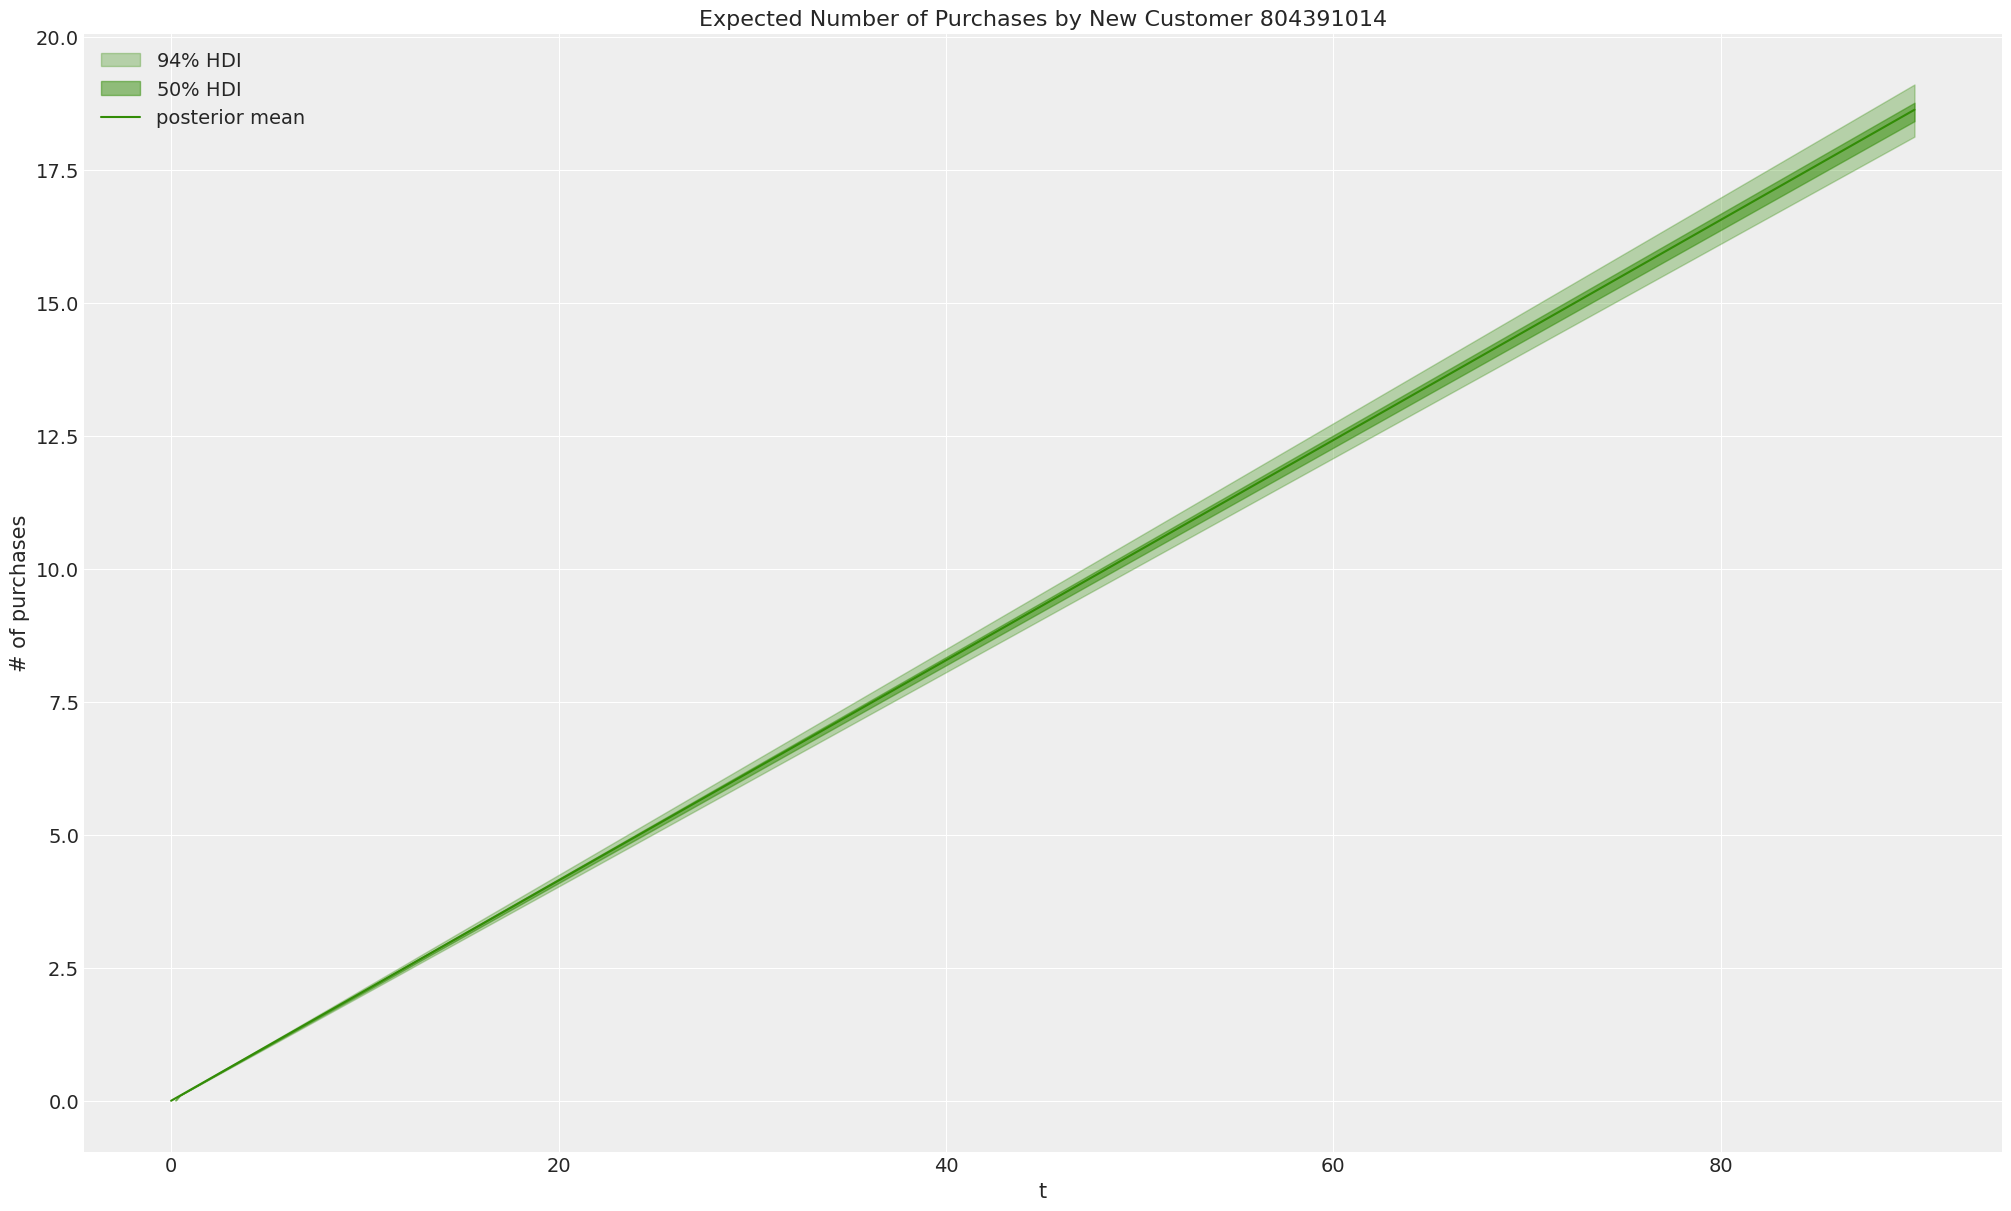

In [125]:
expected_purchases_over_time_new_customer = concat(
    objs=[
        pnbd_model.expected_purchases_new_customer(
            data=train_data,
            t=t,
        ).sel(customer_id=account_id)
        for t in tqdm(t_range)
    ],
    dim="t",
).transpose(..., "t")

ax = plt.axes()
# Set the figure size
ax.figure.set_size_inches(20, 12)

az.plot_hdi(
    t_range,
    expected_purchases_over_time_new_customer,
    hdi_prob=0.94,
    color="C2",
    fill_kwargs={"alpha": 0.3, "label": "$94 \\%$ HDI"},
    ax=ax,
)
az.plot_hdi(
    t_range,
    expected_purchases_over_time_new_customer,
    hdi_prob=0.5,
    color="C2",
    fill_kwargs={"alpha": 0.5, "label": "$50 \\%$ HDI"},
    ax=ax,
)
ax.plot(
    t_range,
    expected_purchases_over_time_new_customer.mean(dim=("chain", "draw")),
    color="C2",
    label="posterior mean",
)
ax.legend(loc="upper left")
ax.set(
    title=f"Expected Number of Purchases by New Customer {account_id}",
    ylabel="# of purchases",
    xlabel="t",
)
plt.show();

### Probability of $n$ Transactions In the Future

In [126]:
account_id: str = str(rng.choice(train_data["customer_id"], size=1)[0])
n_purchases_array: np.ndarray = np.repeat([1, 3, 6, 9, 12, 15], 6)
time_periods_array: np.ndarray = np.tile([15, 30, 45, 60, 75, 90], 6)

# Calculate expected purchase probabilities for each (n_purchases, future_t) combination
results = [
    pnbd_model.expected_purchase_probability(
        data=train_data,
        n_purchases=n_purchases,
        future_t=time_periods,
    ).sel(customer_id=account_id)
    for n_purchases, time_periods in tqdm(
        zip(n_purchases_array, time_periods_array, strict=False),
        total=len(n_purchases_array),
        desc="Calculating expected purchase probabilities",
    )
]

# Concatenate the results along the customer_id dimension
expected_purchase_prob: DataArray = concat(results, dim="customer_id")

# Collapse any extra dimensions (e.g. a "draw" dimension) to get one value per combination
expected_purchase_prob: DataArray = expected_purchase_prob.mean(dim=["chain", "draw"])

Calculating expected purchase probabilities: 100%|██████████| 36/36 [05:14<00:00,  8.73s/it]


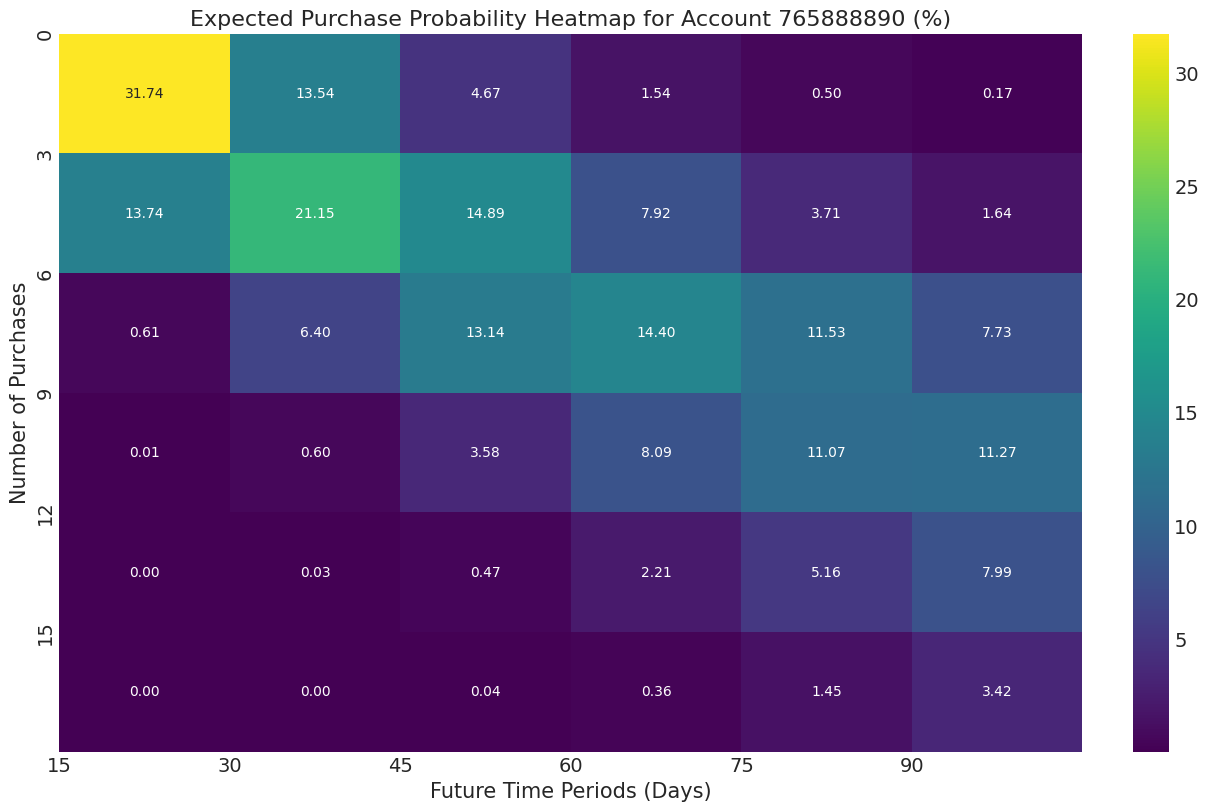

In [128]:
heatmap_values: np.ndarray = expected_purchase_prob.values.reshape(6, 6) * 100

fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(heatmap_values, annot=True, fmt=".2f", cmap="viridis", ax=ax)
plt.title(f"Expected Purchase Probability Heatmap for Account {account_id} (%)")
plt.xlabel("Future Time Periods (Days)")
plt.ylabel("Number of Purchases")
plt.xticks(ticks=range(6), labels=[15, 30, 45, 60, 75, 90])
plt.yticks(ticks=range(6), labels=[0, 3, 6, 9, 12, 15])
plt.show();

## Spend Per Transaction Model

### 1. Assumptions of the Gamma‐Gamma Model

The Gamma-Gamma model ([Fader et al. 2005](https://www.brucehardie.com/notes/025/gamma_gamma.pdf)) is built on three key assumptions:

1. **Transaction Values**: The monetary value of an account’s transaction varies randomly around its *average* transaction value.  
   $$
     z_i \quad\text{fluctuates around}\quad \zeta.
   $$

2. **Stability of Average Transaction Value**: Each account has a constant (but unobserved) *mean* transaction value $\zeta$. This $\zeta$ is specific to each account but *does not vary over time* for that account.

3. **Independence**: The distribution of average transaction values across accounts (i.e., the distribution of $\zeta$ in the population) is assumed *independent* of the *transaction process* (i.e., how many purchases get made and when).

### 2. Observing Transaction Data

For an account with $x$ observed transactions, let the values be $z_1, z_2, \ldots, z_x$. We define the *observed average* transaction value as:

$$
\bar{z}
\;=\;
\frac{1}{x} \sum_{i=1}^x z_i
$$

We will use $\bar{z}$ (and $x$) to learn about that account’s *true* mean transaction value $\zeta$.

### 3. Parametrization and Model Development

#### 3.1 Per‐Transaction Gamma Distribution

- **Within** a single account, each transaction $z_i$ follows a Gamma distribution with shape parameter $p$ and rate parameter $\nu$:
  $$
    z_i \;\sim\; \Gamma(p,\nu)
  $$
- The expected value of each $z_i$ is
  $$
    \mathbb{E}[z_i \mid p,\nu]
    \;=\;
    \frac{p}{\nu}
  $$
  We often denote an account’s *true* average transaction value as $\zeta = \frac{p}{\nu}$.

#### 3.2 Total Spend and Average Transaction Value

- **Total spend** across $x$ transactions is the sum $z_1 + z_2 + \ldots + z_x$. Because of the *convolution* property of Gamma:
  $$
    z_1 + z_2 + \ldots + z_x
    \;\sim\;
    \Gamma(p\,x,\; \nu)
  $$
- The *average* transaction value $\bar{z} = \frac{1}{x}\sum_{i=1}^x z_i$ is then a *scaled* Gamma random variable:
  $$
    \bar{z} 
    \;\sim\;
    \Gamma\!\bigl(p\,x,\; \nu\,x\bigr)
  $$

#### 3.3 Heterogeneity in $\nu$

- Different accounts may have different $\nu$. We model that heterogeneity by letting $\nu$ itself be Gamma $(q,\gamma)$‐distributed across the population:
  $$
    \nu 
    \;\sim\;
    \Gamma(q,\;\gamma).
  $$
- Equivalently, since $\zeta = \frac{p}{\nu}$, the *account‐specific* mean transaction value $\zeta$ follows an Inverse‐Gamma distribution with parameters $q$ and $p\gamma$.

Putting these assumptions together (Gamma for $z_i$ *conditional* on $\nu$, and Gamma for $\nu$ *across* accounts) yields the **Gamma‐Gamma** (GG) model.

### 4. Posterior Inference: $E(Z \mid \bar{z}, x)$

After observing $x$ transactions with average $\bar{z}$ for a specific account, we want the **posterior mean** of that account’s true average transaction value, $\zeta$. Denoting $\zeta\equiv Z$ (the latent mean), the key derivation shows:

$$
E(Z \mid p, q, \gamma;\; \bar{z}, x)
\;=\;
\frac{p\,\bigl(\gamma + x\,\bar{z}\bigr)}{p\,x + q - 1}.
$$

#### 4.1 Weighted‐Average Interpretation

A very insightful way to write it is:

$$
E(Z \mid p, q, \gamma;\; \bar{z}, x)
\;=\;
\underbrace{
  \Bigl(\frac{q-1}{\,p\,x + q - 1\,}\Bigr)
}_{
  \text{weight on the prior mean}
}
\underbrace{
  \frac{p\,\gamma}{\,q-1\,}
}_{
  \text{population mean of } Z
}
\;+\;
\underbrace{
  \Bigl(\frac{p\,x}{\,p\,x + q - 1\,}\Bigr)
}_{
  \text{weight on the sample mean}
}
\underbrace{
  \bar{z}
}_{
  \text{observed mean transaction value}
}
$$

1. **$\frac{p\gamma}{q-1}$** is the *population* (prior) mean of $Z$.  
2. $\bar{z}$ is the account’s *observed* mean.  
3. The weights sum to 1:
   $$
     \frac{q-1}{p\,x + q-1}
     \;+\;
     \frac{p\,x}{p\,x + q-1}
     \;=\;1.
   $$
4. As $x$ (the number of observed transactions) grows large $\to \infty$, the weight on $\bar{z}$ increases, and $\bar{z}$ dominates the posterior mean. With little data ($x$ small), the model shrinks the estimate toward the population mean $\frac{p\gamma}{q-1}$.

### 5. Symbol Glossary

1. **$z_i$**: Observed value of the $i$-th transaction for a given account.

2. **$\bar{z}$**: Sample mean transaction value for a given account with $x$ observations:  
   $\displaystyle \bar{z}=\frac{1}{x}\sum_{i=1}^x z_i$

3. **$Z\equiv \zeta$**: The *latent* (unobserved) true mean transaction value for a given account.

4. **$p$**: Shape parameter of the within‐account Gamma distribution $\Gamma(p,\nu)$.

5. **$\nu$**: *Rate* parameter of the within‐account Gamma distribution (itself random across accounts).

6. **$q$**: Shape parameter of the Gamma distribution for $\nu$ across accounts, $\nu\sim\Gamma(q,\gamma)$.

7. **$\gamma$**: Rate parameter of the Gamma distribution for $\nu$ across accounts.

8. **$x$**: Number of observed transactions for this particular account.

9. **$\displaystyle E(Z)$ or $E(Z \mid p,q,\gamma)$**: Population‐level mean of $\zeta$. (It equals $\tfrac{p\,\gamma}{q-1}$ for $q>1$)

10. **$E(Z \mid \bar{z}, x)$**: Posterior mean of $Z$ after observing $x$ transactions with sample mean $\bar{z}$.

Filter out customers who have made only one purchase:

In [11]:
train_data_non_zero: pd.DataFrame = train_data.loc[train_data["frequency"] > 0]

train_data_non_zero.shape

(4893, 5)

### Independence Assumption

The Gamma-Gamma model assumes that there is **no relationship** between the monetary value and the purchase frequency.

When we’re dealing with large datasets, even very small correlations can become “statistically significant” due to high power, even if they are practically negligible. To robustly check the assumption that average spend and purchase frequency are uncorrelated (as required by the Gamma-Gamma model), we can use methods that are less sensitive to outliers and the nuances of big data.

#### Rank-Based Correlation Measures

Rank-based methods (e.g., Spearman’s rank correlation and Kendall’s tau) are non-parametric. They assess monotonic relationships rather than strict linear relationships and are less sensitive to outliers. This makes them more robust in many real-world settings.

In [63]:
pearson_res = pearsonr(
    x=train_data_non_zero["frequency"], y=train_data_non_zero["monetary_value"]
)

spearman_res = spearmanr(
    a=train_data_non_zero["frequency"], b=train_data_non_zero["monetary_value"]
)

kendall_res = kendalltau(
    x=train_data_non_zero["frequency"], y=train_data_non_zero["monetary_value"]
)


print(f"Pearson Correlation: {pearson_res[0]:.2f} | p-value: {pearson_res[1]:.2f}")
print(
    f"Spearman Correlation: {spearman_res.statistic:.2f} | p-value: {spearman_res.pvalue:.2f}"
)
print(f"Kendall Tau: {kendall_res.statistic:.2f} | p-value: {kendall_res.pvalue:.2f}")

Pearson Correlation: 0.43 | p-value: 0.00
Spearman Correlation: 0.62 | p-value: 0.00
Kendall Tau: 0.48 | p-value: 0.00


#### Robust Regression & Outlier-Robust Techniques

Outliers or influential points can distort the results. Robust regression methods help in understanding the relationship while down-weighting the effect of outliers.

In [64]:
scaled_monetary_value: np.ndarray = (
    RobustScaler()
    .fit_transform(train_data_non_zero["monetary_value"].values.reshape(-1, 1))
    .reshape(-1)
)

X: np.ndarray = sm.add_constant(scaled_monetary_value)

# Fit robust linear model
rlm_model: RLM = RLM(
    endog=train_data_non_zero["frequency"], exog=X, M=sm.robust.norms.HuberT()
)
rlm_results: RLMResultsWrapper = rlm_model.fit()
rlm_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:              frequency   No. Observations:                 4893
Model:                            RLM   Df Residuals:                     4891
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Wed, 05 Feb 2025                                         
Time:                        18:10:59                                         
No. Iterations:                    36                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         47.1029      0.516     91.214      0.000      46.091      48.115
x1            29.5813      0.177    167.250      0.000      29.235      29.928
==============================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

#### Bootstrapping for Confidence Intervals

Bootstrapping can provide confidence intervals for correlation coefficients. This is particularly useful in large datasets where even small effects become statistically significant. Bootstrapped intervals can help us assess whether the magnitude of the correlation is practically meaningful.

In [65]:
for func in ["pearson", "spearman"]:
    ci: np.ndarray = pg.compute_bootci(
        x=train_data_non_zero["frequency"],
        y=train_data_non_zero["monetary_value"],
        func=func,
        paired=True,
        confidence=0.95,
        n_boot=5000,
        seed=seed,
    )
    print(
        f"Correlation between Frequency and Monetary Value using {func} correlation: "
        f"{ci[0]:.2f} - {ci[1]:.2f}"
    )

Correlation between Frequency and Monetary Value using pearson correlation: 0.33 - 0.59
Correlation between Frequency and Monetary Value using spearman correlation: 0.59 - 0.64


### Empirical Distribution of Average Transaction Values

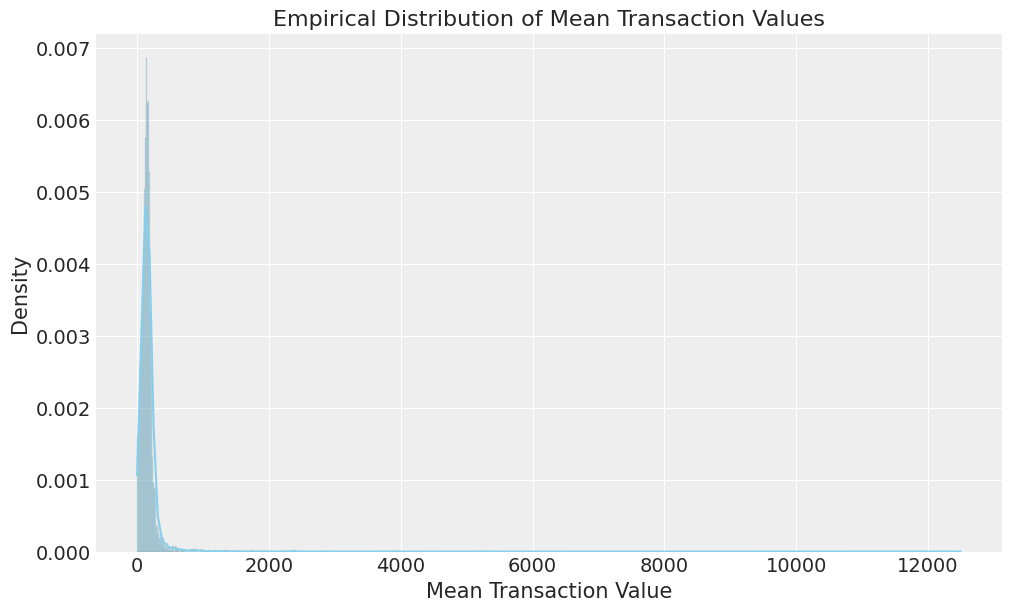

In [66]:
monetary_values: np.ndarray = train_data_non_zero["monetary_value"].values

plt.figure(figsize=(10, 6))
sns.histplot(
    monetary_values,
    bins=np.histogram_bin_edges(a=monetary_values, bins="auto"),
    kde=True,
    stat="density",
    color="skyblue",
    edgecolor="black",
)
plt.title("Empirical Distribution of Mean Transaction Values")
plt.xlabel("Mean Transaction Value")
plt.ylabel("Density")
plt.show();

Use scipy's `gamma` distribution to fit the empirical distribution of monetary values:

In [67]:
a_fit, loc_fit, scale_fit = gamma.fit(monetary_values)
print(f"Fitted parameters: shape = {a_fit}, rate = {1 / scale_fit:.3f}")

Fitted parameters: shape = 0.00023299656497147901, rate = 0.236


### Prior Specifications

The Gamma-Gamma model parameters $ p $, $ q $, and $ \nu $ are estimated using Bayesian inference. Again, the priors for these parameters are informed by MLE estimates from a frequentist Gamma-Gamma model fit to the data. This approach ensures that the priors are centered around reasonable values, improving the stability and predictive performance of the Bayesian model.

1. **Fit a frequentist Gamma-Gamma model** to the RFM data:

   - `frequency`: Total number of repeat purchases for each customer.
   - `monetary_value`: Mean (or total) spend for those repeat purchases.

2. **Extract the MLE parameters** $(p, q, \nu) $ from the fitted model.

3. **Map MLE estimates into Bayesian priors**:

   - For $ p $ and $ q $, the priors are directly set using the MLE estimates with means $\frac{\text{shape}}{\text{rate}} = \frac{\text{MLE}}{1.0}$:
     $$
     p_{\text{prior}} = \text{Prior}(\text{Gamma}, \alpha=p_{\text{MLE}}, \beta=1.0)
     $$
     $$
     q_{\text{prior}} = \text{Prior}(\text{Gamma}, \alpha=q_{\text{MLE}}, \beta=1.0)
     $$

   - For $ \nu $, the prior can either use the MLE estimate or a default moderate prior:
     $$
     \nu_{\text{prior}} = \text{Prior}(\text{Gamma}, \alpha=2.0, \beta=\nu_{\text{MLE}}) \quad \text{(if using MLE)}
     $$
     $$
     \nu_{\text{prior}} = \text{Prior}(\text{Gamma}, \alpha=2.0, \beta=0.2) \quad \text{(default)}
     $$


In [68]:
model_config_mle_spend: Dict[str, Prior] = create_spend_model_config_mle(
    rfm_data=train_data_non_zero,
    use_mle_for_v=True,
)

model_config_mle_spend

{'p_prior': Prior("Gamma", alpha=0.28028877567967475, beta=1.0),
 'q_prior': Prior("Gamma", alpha=6.750471754913227, beta=1.0),
 'v_prior': Prior("Gamma", alpha=2.0, beta=3629.9758366029264)}

#### $p_{\text{prior}}$

In [69]:
p_alpha_prior: float = model_config_mle_spend["p_prior"].parameters["alpha"]
p_beta_prior: float = model_config_mle_spend["p_prior"].parameters["beta"]
p_prior_mean: float = p_alpha_prior / p_beta_prior

print("Prior mean for p:", p_prior_mean)

Prior mean for p: 0.28028877567967475


This suggests that the average transaction value is relatively low, as $p$ influences the shape of the Gamma distribution for transaction values.

#### $q_{\text{prior}}$

In [70]:
q_alpha_prior: float = model_config_mle_spend["q_prior"].parameters["alpha"]
q_beta_prior: float = model_config_mle_spend["q_prior"].parameters["beta"]
q_prior_mean: float = q_alpha_prior / q_beta_prior

print("Prior mean for q:", q_prior_mean)

Prior mean for q: 6.750471754913227


A higher $q$ indicates less variability in the rate parameter $\nu$, which controls the spread of transaction values around the average across customers.

#### $\nu_{\text{prior}}$

In [71]:
v_alpha_prior: float = model_config_mle_spend["v_prior"].parameters["alpha"]
v_beta_prior: float = model_config_mle_spend["v_prior"].parameters["beta"]
v_prior_mean: float = v_alpha_prior / v_beta_prior

print("Prior mean for v:", v_prior_mean)

Prior mean for v: 0.000550967854891199


#### Population (Prior) Average Transaction Value ($\zeta$)

The prior specification has implies the following average transaction value for $x$ transactions:

$$
E(Z \mid p, q, \gamma)=\frac{p \gamma}{q-1}
$$

In [73]:
prior_expected_spend: float = p_prior_mean * v_beta_prior / (q_prior_mean - 1)

print(
    f"Expected Spend: {prior_expected_spend:.2f} | Actual Average Spend: {monetary_values.mean():.2f}"
)

Expected Spend: 176.93 | Actual Average Spend: 163.81


### Model Fitting

#### Model

> Experimentations of this dataset reveals that priors based on MLE estimates are too strong, while model generalization improves with half-flat priors. Half-flat priors are weakly informative, constraining parameters to valid ranges (e.g., non-negative) without overly influencing estimates.

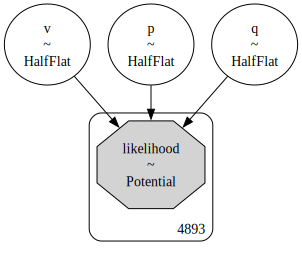

In [12]:
gg_model: GammaGammaModel = GammaGammaModel(data=train_data_non_zero, model_config=None)
gg_model.build_model()
gg_model.graphviz()

#### Maximum A Posteriori (MAP) Estimate

In [13]:
idata_map: pd.DataFrame = gg_model.fit(fit_method="map").posterior.to_dataframe()
idata_map

Output()

,,p,q,v
chain,draw,,,
0,0,0.280288,6.750407,3629.947481


#### MCMC 

In [14]:
idata_mcmc: az.InferenceData = gg_model.fit(
    fi_method="mcmc", **{"draws": 2000, "chains": 4, "random_seed": seed, "tune": 2000}
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, q, v]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 18 seconds.


#### Model Persistence

In [ ]:
gg_model.save(str(model_path / "gg_model.nc"))

#### Diagnostics

In [15]:
gg_model.fit_summary()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,0.280,0.009,0.264,0.298,0.000,0.000,2695.0,3468.0,1.0
q,6.766,0.208,6.377,7.151,0.004,0.003,2213.0,3007.0,1.0
v,3644.663,203.954,3280.256,4034.507,4.565,3.228,1994.0,2485.0,1.0


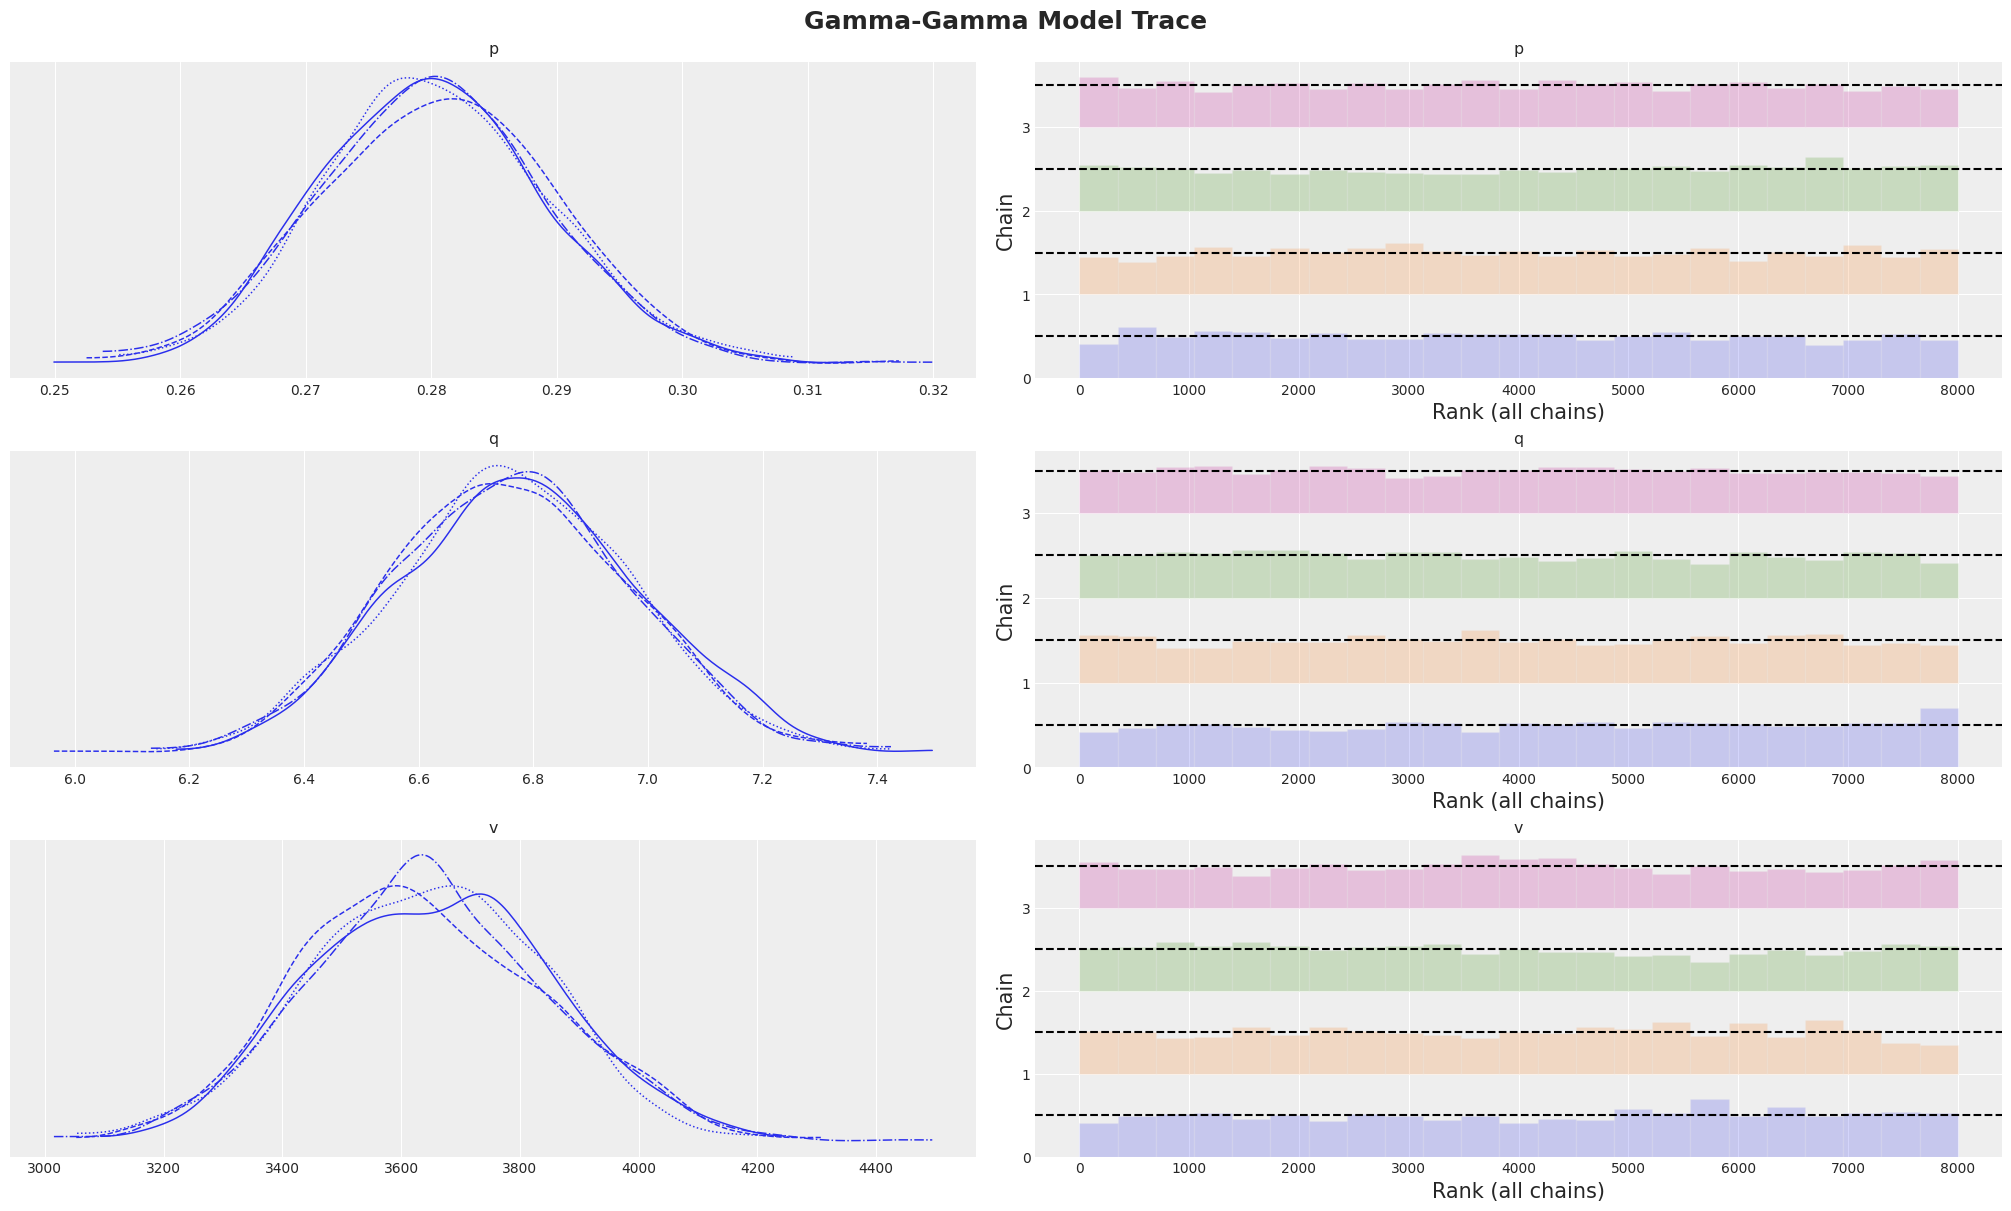

In [16]:
az.plot_trace(
    idata_mcmc,
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (20, 12), "layout": "constrained"},
)
plt.gcf().suptitle(
    "Gamma-Gamma Model Trace",
    fontsize=18,
);

#### Comparison With MAP Estimate

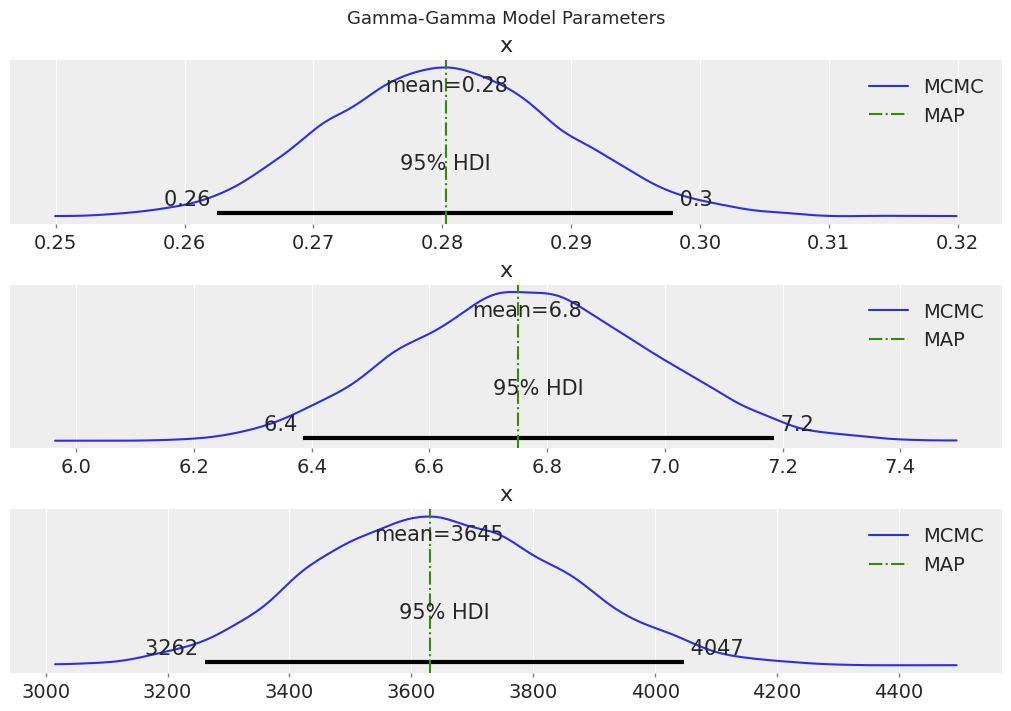

In [211]:
fig, axes = plt.subplots(
    nrows=3, ncols=1, figsize=(10, 7), sharex=False, sharey=False, layout="constrained"
)

for i, var_name in enumerate(["p", "q", "v"]):
    ax = axes[i]
    az.plot_posterior(
        idata_mcmc.posterior[var_name].values.flatten(),
        color="C0",
        point_estimate="mean",
        hdi_prob=0.95,
        ax=ax,
        label="MCMC",
    )
    ax.axvline(x=idata_map[var_name].item(), color="C2", linestyle="-.", label="MAP")
    ax.legend(loc="upper right")

plt.gcf().suptitle(
    "Gamma-Gamma Model Parameters",
    fontsize=13,
);

### Conditional Expectation of Average Transaction Value For An Account $E(Z \mid p, q, \gamma ; \bar{z}, x)$

In [23]:
expected_spend: DataArray = gg_model.expected_customer_spend(
    data=train_data_non_zero,
)

expected_spend.shape

(4, 2000, 4893)

In [40]:
summary: pd.DataFrame = az.summary(data=expected_spend, kind="stats")

summary

,mean,sd,hdi_3%,hdi_97%
x[100088067],136.793,0.865,135.183,138.420
x[100108752],136.145,1.843,132.623,139.536
x[100328049],164.403,0.447,163.568,165.216
x[100663626],165.755,0.939,163.989,167.465
x[100737756],229.676,0.550,228.686,230.748
...,...,...,...,...
x[999086814],296.378,0.561,295.338,297.399
x[999257059],199.900,0.330,199.287,200.519
x[999258704],137.655,0.782,136.209,139.136
x[999283629],174.721,0.291,174.197,175.282


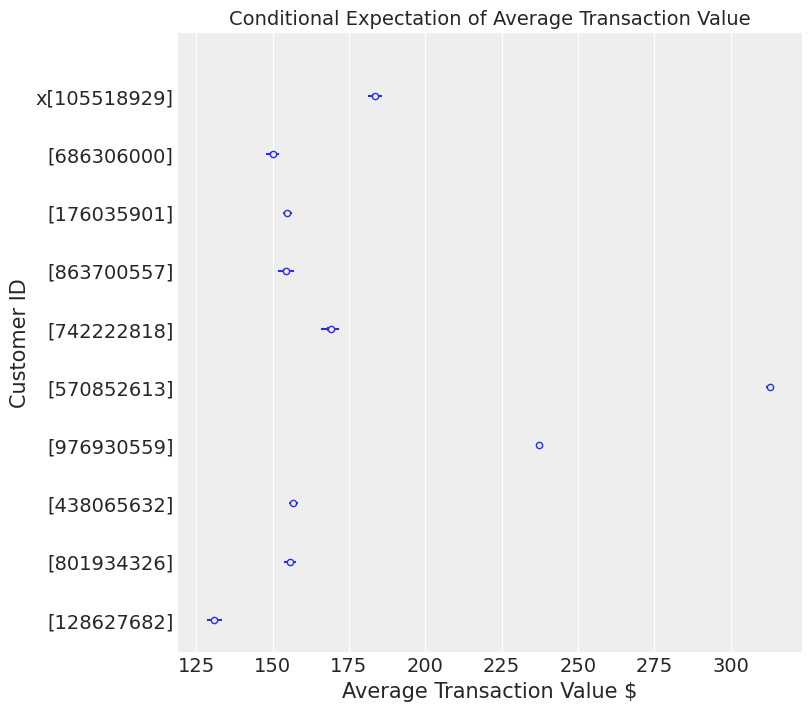

In [53]:
accounts: np.ndarray = rng.choice(
    range(train_data_non_zero.shape[0]), size=10, replace=False
).tolist()

ax, *_ = az.plot_forest(
    data=expected_spend.isel(customer_id=accounts), combined=True, figsize=(8, 7)
)
ax.set(xlabel="Average Transaction Value $", ylabel="Customer ID")
ax.set_title("Conditional Expectation of Average Transaction Value", fontsize=14);

### Distribution of Average Transaction Values ($Z$'s) Across All Accounts

In [41]:
mean_expected_spend: DataArray = expected_spend.mean(dim="customer_id")
hdi_prob: float = 0.97
hdi_expected_spend: DataArray = az.hdi(expected_spend, hdi_prob=hdi_prob).to_array()
hdi_lower: float = hdi_expected_spend.sel(hdi="lower").mean(dim="customer_id").item()
hdi_upper: float = hdi_expected_spend.sel(hdi="higher").mean(dim="customer_id").item()

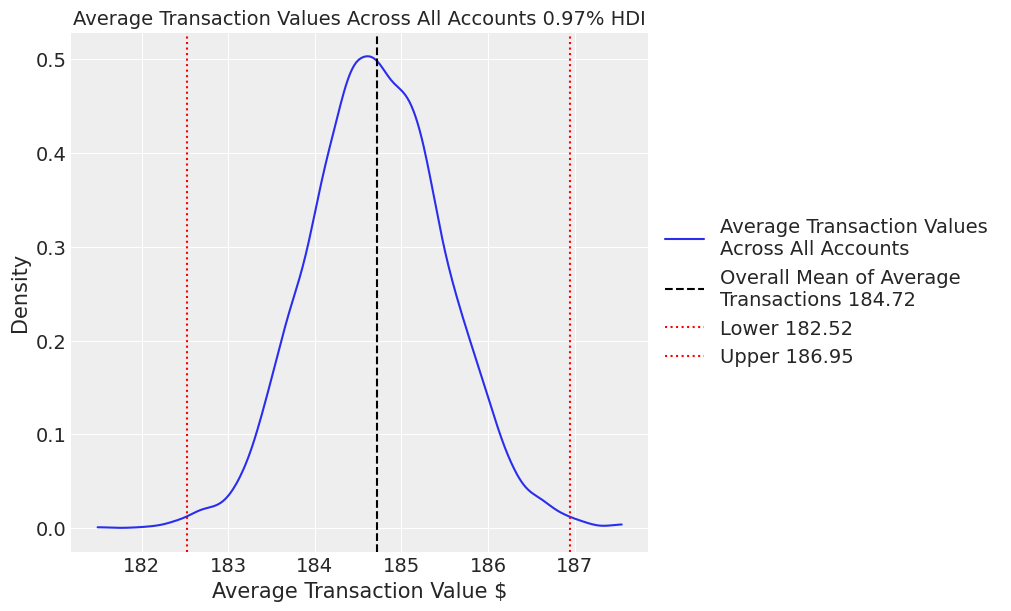

In [54]:
fig, ax = plt.subplots(figsize=(10, 6))
az.plot_dist(
    mean_expected_spend, label="Average Transaction Values \nAcross All Accounts", ax=ax
)
ax.axvline(
    x=mean_expected_spend.mean().item(),
    color="black",
    ls="--",
    label=f"Overall Mean of Average \nTransactions {mean_expected_spend.mean().item():.2f}",
)

ax.axvline(hdi_lower, color="red", linestyle=":", label=f"Lower {hdi_lower:.2f}")
ax.axvline(hdi_upper, color="red", linestyle=":", label=f"Upper {hdi_upper:.2f}")

ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(xlabel="Average Transaction Value $", ylabel="Density")
ax.set_title(
    f"Average Transaction Values Across All Accounts {hdi_prob}% HDI",
    fontsize=14,
)

plt.show();

### Population‐Level (Prior) Mean of $\zeta$ 

This is an inverse-gamma distribution with mean $E(Z \mid p, q, \gamma)=\frac{p \gamma}{q-1}$, which can be used to make inference about new accounts with no transaction history.

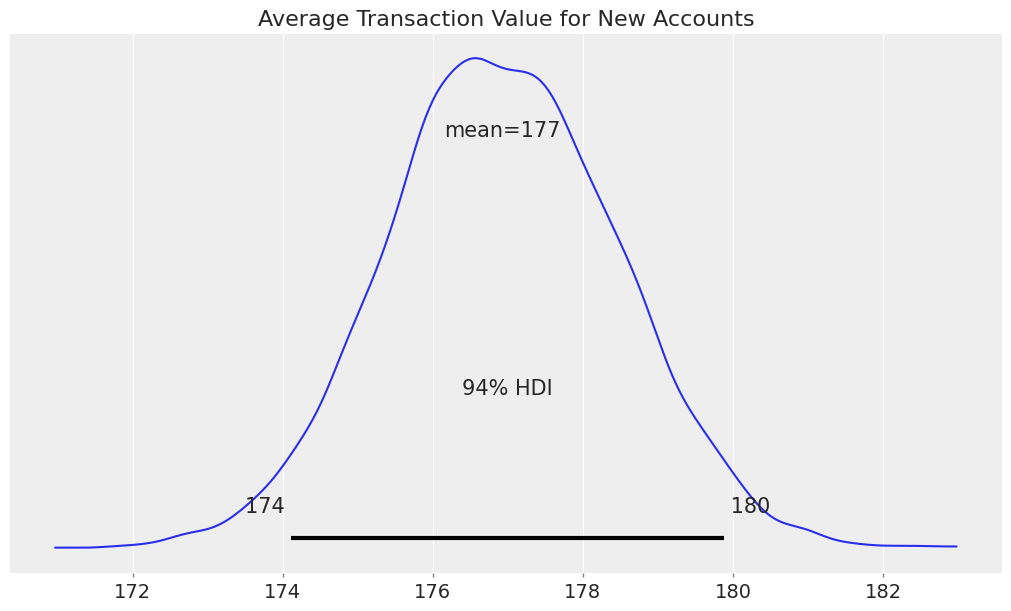

In [56]:
fig, ax = plt.subplots(figsize=(10, 6))
az.plot_posterior(data=gg_model.expected_new_customer_spend(), ax=ax)
plt.title("Average Transaction Value for New Accounts");

## Customer Lifetime Value (CLV)

When combining **Gamma-Gamma** (for *average transaction value*) with a **Pareto/NBD** model (for *number of future transactions*), we can estimate each account’s **lifetime value** (CLV) by summing discounted cash flows over future periods.

### 1. Pareto/NBD: Predicting Future Transactions

- **Pareto/NBD** assumes each account is active for an unobserved amount of time, then permanently “drops out.”  
- It models:
  $$
    \lambda \sim \Gamma(r, \alpha) \quad\text{(purchase rate)},
    \quad
    \mu \sim \Gamma(s, \beta) \quad\text{(dropout rate)},
  $$
  and provides $\mathbb{E}[N_t]$, the *cumulative* expected number of transactions by time $t$.

### 2. Gamma-Gamma: Predicting Average Transaction Value

The **Gamma-Gamma** model is used to estimate an account’s (latent or unobserved) true average transaction value $Z$ (often interpreted as the account’s “spend per transaction”). The derivation is based on the following key points:

- **Within-Account Transaction Model**: For each individual transaction $z_i$ from an account, we assume:
  $$
    z_i \;\sim\; \Gamma\bigl(p,\,\nu\bigr),
  $$
  so that
  $$
    \mathbb{E}[z_i \mid p,\nu] \;=\; \frac{p}{\nu}
  $$
  Here, $Z = \frac{p}{\nu}$ represents the true (but unobserved) average transaction value for the account.

- **Aggregation Across Transactions**: For an account with $x_i$ transactions, the total spend is the sum $z_1 + z_2 + \cdots + z_{x_i}$ which follows a Gamma distribution:
  $$
    \sum_{j=1}^{x_i} z_j \;\sim\; \Gamma\bigl(p\,x_i,\,\nu\bigr)
  $$
  Consequently, the sample average
  $$
    \bar{z}_i = \frac{1}{x_i}\sum_{j=1}^{x_i} z_j
  $$
  follows a scaled Gamma distribution:
  $$
    \bar{z}_i \;\sim\; \Gamma\Bigl(p\,x_i,\,\nu\,x_i\Bigr)
  $$

- **Modeling Heterogeneity**: To capture variation across accounts, the rate parameter $\nu$ is modeled as random:
  $$
    \nu \;\sim\; \Gamma\bigl(q,\,\gamma\bigr).
  $$
  This implies that the latent true average $Z = \frac{p}{\nu}$ follows an Inverse-Gamma distribution across the population.

- **Posterior Inference**: Given $x_i$ observed transactions with sample average $\bar{z}_i$ for account $i$, the posterior mean of $Z$ is derived as:
  $$
    \mathbb{E}\Bigl[Z \mid p,q,\gamma; \,\bar{z}_i, x_i\Bigr]
    \;=\;
    \frac{p\,\bigl(\gamma + x_i\,\bar{z}_i\bigr)}{p\,x_i + q - 1}\
  $$
  This expression can be interpreted as a weighted average between the population mean,
  $$
    \frac{p\,\gamma}{q-1},
  $$
  and the observed sample mean $\bar{z}_i$, with weights $\frac{q-1}{p\,x_i + q - 1}$ and $\frac{p\,x_i}{p\,x_i + q - 1}$, respectively. As $x_i$ increases, more weight is placed on the observed $\bar{z}_i$, whereas for smaller $x_i$ the estimate is shrunk toward the overall population mean.

- **Implementation**: The function **`expected_customer_spend(data)`** implements the Gamma-Gamma model to compute:
  $$
    \mathbb{E}[\text{Average Transaction}_i] \;=\; \frac{p\,\bigl(\gamma + x_i\,\bar{z}_i\bigr)}{p\,x_i + q - 1}
  $$

### 3. Discounted Cash Flow Formulation

To compute **customer lifetime value** (CLV) over a horizon of $T$ periods:

$$
\text{CLV}_i \;=\; \sum_{t=1}^{T} 
  \frac{\Delta N_{i,t} \times \mathbb{E}[\text{Average Transaction}_i]}
  {(1 + \delta)^{t}}
$$

where
- $\delta$ = monthly discount rate,
- $\Delta N_{i,t} = \mathbb{E}[N_{i,t}] - \mathbb{E}[N_{i,t-1}]$ are the *new* transactions predicted at period $t$ from the Pareto/NBD model,
- $\mathbb{E}[\text{Average Transaction}_i]$ is computed from the Gamma-Gamma model as described above.

### Implementation Details

- **`expected_purchases(data, future_t)`** from the Pareto/NBD model returns $\mathbb{E}[N_t]$, the *cumulative* number of transactions by time $t$.  

- **`expected_customer_spend(data)`** from the Gamma-Gamma model returns $\mathbb{E}[\text{Average Transaction}_i]$ computed as:
  $$
    \frac{p\,\bigl(\gamma + x_i\,\bar{z}_i\bigr)}{p\,x_i + q - 1}\,
  $$

- **`customer_lifetime_value(transaction_model, data, future_t, discount_rate, time_unit)`**:
  
  1. Uses the Gamma-Gamma predictions to assign a column `future_spend` = $\mathbb{E}[\text{Average Transaction}_i]$. 
 
  2. Loops through monthly increments of time (converted to days/weeks if needed).  

  3. Computes incremental transactions $\Delta N_t$ using differences of the cumulative predictions from the Pareto/NBD model.  

  4. Sums the products $\Delta N_t \times \mathbb{E}[\text{Average Transaction}_i]$, discounting each period’s value by $(1 + \delta)^{-t}$.

The final **xarray** `DataArray` returned contains the estimated CLV for each customer, reflecting both the **average transaction value** (modeled via Gamma-Gamma) and the **transaction frequency** (modeled via Pareto/NBD) over the specified horizon with optional discounting.

### Load Models

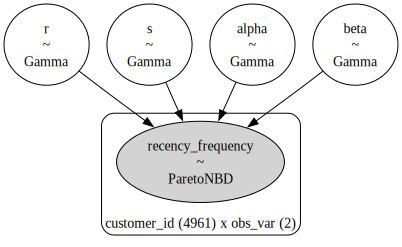

In [74]:
pnbd_model: ParetoNBDModel = ParetoNBDModel.load(
    str(model_path / "pnbd_model_thin_20.nc")
)

pnbd_model.graphviz()

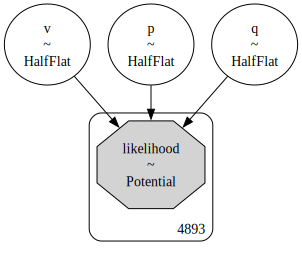

In [75]:
gg_model: GammaGammaModel = GammaGammaModel.load(str(model_path / "gg_model.nc"))

gg_model.graphviz()

### Calculations

In [76]:
future_t_in_months: int = 12
monthly_discount_rate: float = 0.01

clv_estimates: DataArray = gg_model.expected_customer_lifetime_value(
    transaction_model=pnbd_model,
    data=train_data,
    future_t=future_t_in_months,  # This must be in months
    discount_rate=monthly_discount_rate,  # This also must be in months
    time_unit="D",
)

In [77]:
clv_summaries: pd.DataFrame = az.summary(data=clv_estimates, kind="stats")
clv_summaries

,mean,sd,hdi_3%,hdi_97%
x[100088067],8135.667,2.163,8131.731,8139.576
x[100108752],3657.101,3.888,3649.810,3664.309
x[100328049],12456.966,3.152,12451.175,12462.796
x[100663626],3789.523,2.818,3784.591,3795.058
x[100737756],27673.423,7.843,27658.485,27687.909
...,...,...,...,...
x[999086814],79243.667,26.639,79197.232,79296.470
x[999257059],24244.892,6.860,24231.335,24257.040
x[999258704],8898.625,2.228,8894.569,8902.639
x[999283629],19323.257,5.220,19313.436,19332.693


### Interpretation

#### Layperson-Friendly Explanation

> We have a table that shows, for each account, an **expected lifetime value**—how much we predict they’ll spend in total. The **mean** is our best guess for each person’s total spend over the time period (12 months), while **sd** tells us how uncertain we are: a bigger number means more variability in that prediction.
> 
> The **3%** and **97%** columns show what we call a “credible interval”—this is a range that’s likely to contain the true value. For example, for the first account, the mean is about 8,135 dollars, and we estimate there’s only a 3% chance the true value is below about 8,131 dollars, and only a 3% chance it’s above about 8,139 dollars. 
> 
> Keep in mind that these figures come from a **probabilistic model** (Pareto/NBD for transactions plus Gamma-Gamma for spending), which uses past data to project the future. That means the predictions assume behavior stays roughly consistent and that the model’s assumptions hold true.


#### More Technical / Rigorous Explanation

> Each row corresponds to a single account’s **posterior distribution** of estimated lifetime value (CLV), integrating over both their predicted number of future transactions (via Pareto/NBD) and their predicted average transaction amount (via Gamma-Gamma). We summarize this posterior by four key statistics:
> 
> 1. **mean**: The posterior mean of the account’s predicted total monetary value.
> 2. **sd**: The posterior standard deviation, reflecting how spread out or uncertain the estimate is.
> 3. **hdi_3%** and **hdi_97%**: These are the lower and upper bounds of the 94% highest-density interval (HDI). Concretely, there’s a 94% probability that the true CLV for this account lies within that range, under our model’s assumptions.
> 
> For instance, if we look at account **999389635**, we see:
> - A **mean** of about 1,314.63 dollars, meaning that on average, our model thinks this account’s lifetime value will be around $1,315.
> - A **sd** of roughly 3.58, indicating modest uncertainty.
> - A **hdi_3%** of about 1,307.81 and **hdi_97%** of about 1,321.13, so there’s relatively little range—our model is quite confident this account’s CLV will be in the low thirteen-hundreds.
> 
> However, these estimates rely on key assumptions of the Pareto/NBD + Gamma-Gamma models: **stationary purchasing rates**, consistent spending behavior, and a particular prior distribution for parameters. If real account behavior changes in ways not captured by the model, the estimates could be off.


#### Key Caveats & Assumptions to Mention

1. **Historical Behavior**: The model extrapolates from each account’s past transactions, assuming future habits remain similar.
2. **External Factors**: Promotions, economic shifts, or changes in account needs can invalidate these estimates.
3. **Model Uncertainty**: Even if the mean looks precise, a wide standard deviation or wide credible interval implies much uncertainty in that particular account’s outcome.
4. **Discount Rate**: If we incorporate discounting, the final dollar figures might shift to reflect present-value assumptions. If we haven’t applied discounting, that’s another assumption (money doesn’t lose value over time).

All told, these numbers provide **probabilistic** guidance about future spending, not guarantees.

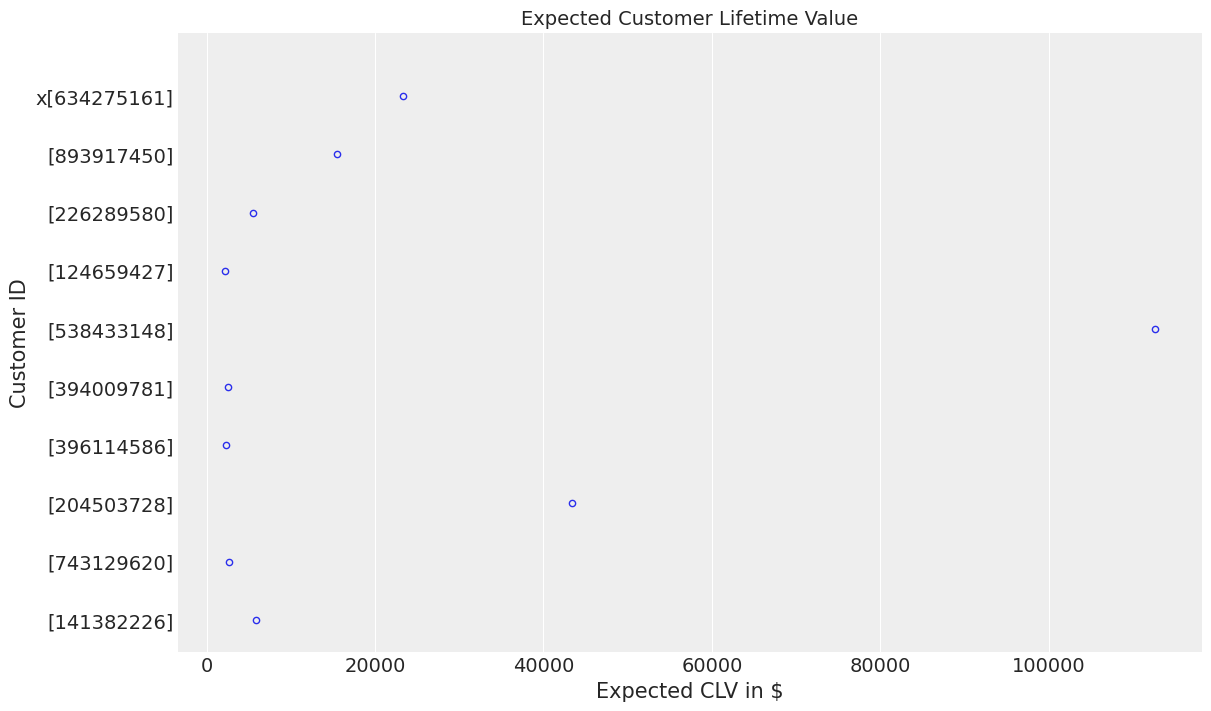

In [213]:
accounts: np.ndarray = rng.choice(
    range(train_data.shape[0]), size=10, replace=False
).tolist()

az.plot_forest(
    data=clv_estimates.isel(customer_id=accounts), combined=True, figsize=(12, 7)
)
plt.xlabel("Expected CLV in $")
plt.ylabel("Customer ID")
plt.title(
    "Expected Customer Lifetime Value",
    fontsize=14,
)
plt.show();

## Sensitivity Analysis

As part of a sensitivity analysis, we seek a transformation to the frequency data so as to reduce the linear and non‐linear correlation between monetary value and frequency. Such correlation is evidence of dependence between the two variables, which violates the assumptions underlying the Gamma-Gamma model.

The transformation will involve:

1. **Scaling and Spline Transformation:** Scale the monetary value using a robust scaler and transform it using a cubic spline basis with 4 degrees of freedom. This provides a flexible, non-linear representation that can better capture the non-linear relationship between monetary value and frequency.

2. **Poisson Regression:** Fit a Poisson regression model (using a log link) to predict the expected frequency based on the transformed monetary value.

3. **Residual Computation and Capping:** Compute the additive residuals (observed frequency minus predicted frequency) and cap these residuals at appropriate percentiles (0.5th and 99.5th) to limit the impact of extreme values. This is the "remaining" component of frequency after removing the systematic relationship with monetary value.

4. **Recalibration with a Robust Baseline:** Use the median observed frequency as a baseline. This approach shifts the adjusted values back to a realistic scale, ensuring that the residual adjustments do not lead to implausibly low or negative frequencies that could destabilize further analyses.

5. **Ensuring Positivity:** Finally, ensure that the adjusted frequency is at least 1 to avoid issues in subsequent analyses during MAP and MCMC estimation.

### Transformation Steps

Define the following variables:

- $y$ is the observed frequency.
- $x$ is the monetary value.
- $x_{\text{scaled}}$ is the robustly scaled monetary value.
- $\phi(x_{\text{scaled}})$ is the cubic spline transformation of $x_{\text{scaled}}$ with 4 degrees of freedom. Many implementations (e.g., via a Spline Transformer) construct a basis expansion of the input features:

    $$
    \phi(x_{\text{scaled}}) = \begin{bmatrix} B_1(x_{\text{scaled}}) \\ B_2(x_{\text{scaled}}) \\ \vdots \\ B_K(x_{\text{scaled}}) \end{bmatrix}
    $$

    with $K$ basis functions corresponding to 4 degrees of freedom in our case.

In [151]:
X: pd.DataFrame = train_data_non_zero[["monetary_value"]].copy()  # 2D array

robust_scaler: RobustScaler = RobustScaler(unit_variance=True)
X_scaled: np.ndarray = robust_scaler.fit_transform(X)

spline_transformer: SplineTransformer = SplineTransformer(
    degree=3, n_knots=4, include_bias=True
)
X_spline: np.ndarray = spline_transformer.fit_transform(X=X_scaled)

y: np.ndarray = train_data_non_zero["frequency"].values

print("X_spline shape:", X_spline.shape)
print("y shape:", y.shape)

X_spline, y

X_spline shape: (4893, 6)
y shape: (4893,)


(array([[1.52824154e-01, 6.65866608e-01, 1.81305385e-01, 3.85369683e-06,
         0.00000000e+00, 0.00000000e+00],
        [1.59598694e-01, 6.66462488e-01, 1.73938326e-01, 4.91532368e-07,
         0.00000000e+00, 0.00000000e+00],
        [1.48194991e-01, 6.65220496e-01, 1.86575077e-01, 9.43641682e-06,
         0.00000000e+00, 0.00000000e+00],
        ...,
        [1.52453373e-01, 6.65822171e-01, 1.81720274e-01, 4.18168410e-06,
         0.00000000e+00, 0.00000000e+00],
        [1.46633937e-01, 6.64956971e-01, 1.88396930e-01, 1.21613610e-05,
         0.00000000e+00, 0.00000000e+00],
        [1.59018495e-01, 6.66427160e-01, 1.74553720e-01, 6.25037649e-07,
         0.00000000e+00, 0.00000000e+00]]),
 array([46., 11., 60., ..., 52., 90.,  5.]))

#### Step 1. Poisson Regression

We fit a Poisson regression model to estimate the expected frequency. Using a log link function, the model is given by

$$
\log\left(\hat{y}\right) = \beta_0 + \beta_1 \phi_1(x_{\text{scaled}}) + \beta_2 \phi_2(x_{\text{scaled}}) + \cdots + \beta_k \phi_k(x_{\text{scaled}})
$$

This implies that the predicted frequency is

$$
\hat{y} = \exp\left(\beta_0 + \beta_1 \phi_1(x_{\text{scaled}}) + \beta_2 \phi_2(x_{\text{scaled}}) + \cdots + \beta_k \phi_k(x_{\text{scaled}})\right)
$$

In [152]:
poisson_model: sm.GLM = sm.GLM(
    endog=y, exog=X_spline, family=sm.families.Poisson(link=sm.families.links.log())
)
poisson_results: GLMResultsWrapper = poisson_model.fit()

y_pred: np.ndarray = poisson_results.predict(X_spline)

y_pred

array([38.13448197, 24.57024474, 50.7105379 , ..., 39.03329711,
       55.66460275, 25.5388907 ])

#### Step 2. Residual Computation and Capping

We compute the additive residuals as

$$
r = y - \hat{y}
$$

Since extreme residual values can distort the scale, we cap these residuals. Let

$$
r_{\text{capped}} = \text{clip}\Big(r,\ \text{Percentile}_{0.5}(r),\ \text{Percentile}_{99.5}(r)\Big)
$$

where $\text{Percentile}_{p}(r)$ denotes the $p$-th percentile of $r$.

In [121]:
residuals: np.ndarray = y - y_pred

lower_cap: np.float64 = np.percentile(residuals, 0.5)
upper_cap: np.float64 = np.percentile(residuals, 99.5)
residuals_capped: np.ndarray = np.clip(residuals, lower_cap, upper_cap)

residuals_capped

array([  3.26487219, -21.39543206,   8.54318636, ...,   8.61965711,
        35.25499248, -28.18086682])

#### Step 3. Recalibration by Adding a Baseline

To preserve the overall scale of the frequency data and ensure that the adjusted frequency does not fall to zero (which can cause problems downstream in the Gamma-Gamma model), we add back a baseline. In this updated approach, we choose the median observed frequency as the baseline:

$$
y_{\mathrm{adj}}=\operatorname{median}(y)+r_{\text {capped}}
$$


Finally, to ensure positivity, we enforce

$$
y_{\mathrm{adj}}=\max (y_{\text {adj}}, 1)
$$


In [153]:
baseline: np.float64 = np.median(y)
frequency_adjusted: np.ndarray = baseline + residuals_capped
frequency_adjusted_int: np.ndarray = (
    np.round(np.maximum(frequency_adjusted, 1)).astype(int).astype(float)
)

frequency_adjusted_int

array([39., 17., 40., ..., 44., 65., 10.])

### Comparison: Correlation Pre- and Post-Transformation

In [199]:
train_data_non_zero_adj: pd.DataFrame = train_data_non_zero.loc[
    :, ["customer_id", "frequency", "monetary_value"]
].copy()
train_data_non_zero_adj["frequency_adjusted"] = frequency_adjusted_int
train_data_non_zero_adj

,customer_id,frequency,monetary_value,frequency_adjusted
0,100088067,46.0,118.832827,39.0
1,100108752,11.0,59.911817,17.0
2,100328049,60.0,160.103334,40.0
3,100663626,17.0,152.230588,1.0
4,100737756,96.0,240.985938,43.0
...,...,...,...,...
4956,999086814,219.0,307.608767,129.0
4957,999257059,97.0,204.773917,60.0
4958,999258704,52.0,122.107499,44.0
4959,999283629,90.0,174.214221,65.0


In [200]:
for func in ["pearson", "spearman"]:
    ci_pre: np.ndarray = pg.compute_bootci(
        x=train_data_non_zero_adj["frequency"],
        y=train_data_non_zero_adj["monetary_value"],
        func=func,
        paired=True,
        confidence=0.95,
        n_boot=5000,
        seed=seed,
    )

    ci_post: np.ndarray = pg.compute_bootci(
        x=train_data_non_zero_adj["frequency_adjusted"],
        y=train_data_non_zero_adj["monetary_value"],
        func=func,
        paired=True,
        confidence=0.95,
        n_boot=5000,
        seed=seed,
    )

    print(f"Pre-Transformation {func}: {ci_pre[0]:.2f} - {ci_pre[1]:.2f}")
    print(f"Post-Transformation {func}: {ci_post[0]:.2f} - {ci_post[1]:.2f}")
    print("-" * 50)

kendall_pre: float = kendalltau(
    x=train_data_non_zero_adj["frequency"], y=train_data_non_zero_adj["monetary_value"]
).statistic
kendall_post: float = kendalltau(
    x=train_data_non_zero_adj["frequency_adjusted"],
    y=train_data_non_zero_adj["monetary_value"],
).statistic
print(f"Pre-Transformation Kendall Tau: {kendall_pre:.2f}")
print(f"Post-Transformation Kendall Tau: {kendall_post:.2f}")

Pre-Transformation pearson: 0.33 - 0.59
Post-Transformation pearson: 0.09 - 0.25
--------------------------------------------------
Pre-Transformation spearman: 0.59 - 0.64
Post-Transformation spearman: 0.19 - 0.25
--------------------------------------------------
Pre-Transformation Kendall Tau: 0.48
Post-Transformation Kendall Tau: 0.16


### Comparison: Distribution of Frequency Pre- and Post-Transformation

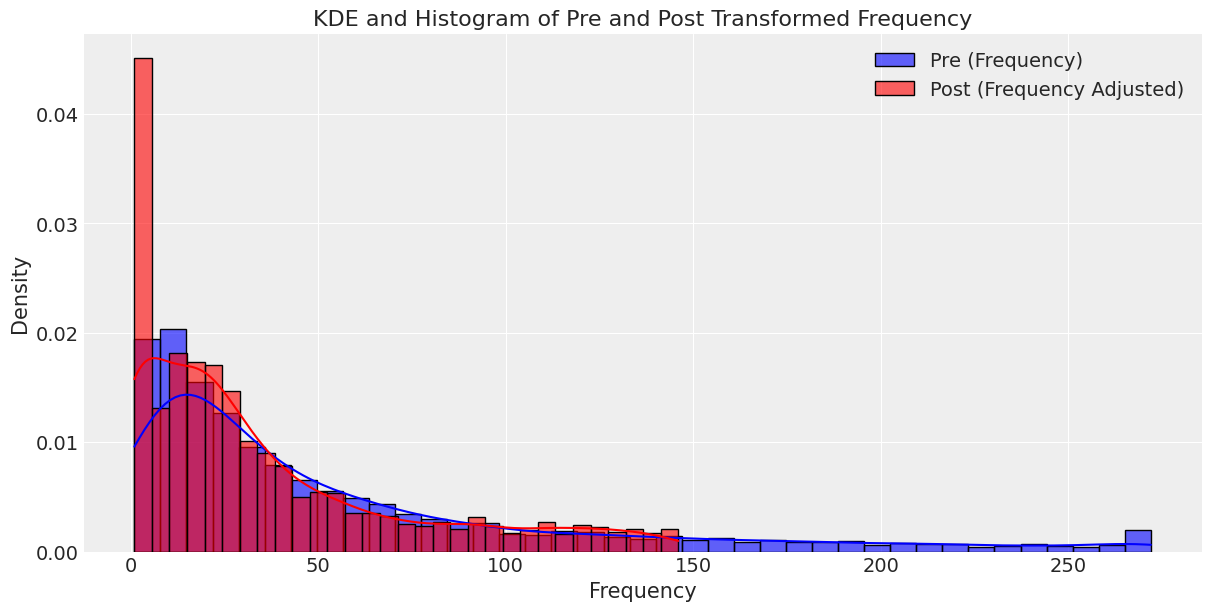

In [202]:
plt.figure(figsize=(12, 6))

sns.histplot(
    train_data_non_zero_adj["frequency"],
    kde=True,
    stat="density",
    color="blue",
    label="Pre (Frequency)",
    alpha=0.6,
)
sns.histplot(
    train_data_non_zero_adj["frequency_adjusted"],
    kde=True,
    stat="density",
    color="red",
    label="Post (Frequency Adjusted)",
    alpha=0.6,
)

plt.title("KDE and Histogram of Pre and Post Transformed Frequency")
plt.xlabel("Frequency")
plt.ylabel("Density")
plt.legend()
plt.show();

### Model Fitting with Adjusted Frequency

Create a new data with `frequency` set to the adjusted frequency:

In [158]:
train_data_non_zero_adj["frequency"] = train_data_non_zero_adj["frequency_adjusted"]
train_data_non_zero_adj.drop(columns=["frequency_adjusted"], inplace=True)
train_data_non_zero_adj

,customer_id,frequency,monetary_value
0,100088067,39.0,118.832827
1,100108752,17.0,59.911817
2,100328049,40.0,160.103334
3,100663626,1.0,152.230588
4,100737756,43.0,240.985938
...,...,...,...
4956,999086814,129.0,307.608767
4957,999257059,60.0,204.773917
4958,999258704,44.0,122.107499
4959,999283629,65.0,174.214221


Define the new model:

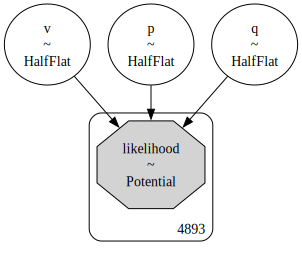

In [159]:
gg_model_adj: GammaGammaModel = GammaGammaModel(
    data=train_data_non_zero_adj, model_config=None
)
gg_model_adj.build_model()
gg_model_adj.graphviz()

MAP estimate:

In [160]:
idata_map_adj: pd.DataFrame = gg_model_adj.fit(
    fit_method="map"
).posterior.to_dataframe()
idata_map_adj

Output()

,,p,q,v
chain,draw,,,
0,0,0.213486,5.799995,3613.788612


MCMC sampling:

In [161]:
idata_mcmc_adj: az.InferenceData = gg_model_adj.fit(
    fit_method="mcmc",
    **{"draws": 2000, "chains": 4, "random_seed": seed, "tune": 2000},
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, q, v]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 19 seconds.


Persist the new model:

In [163]:
gg_model_adj.save(str(model_path / "gg_model_adj.nc"))

Diagnostics with transformed frequency data:

In [164]:
gg_model_adj.fit_summary()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,0.213,0.007,0.199,0.226,0.000,0.000,2009.0,2640.0,1.0
q,5.833,0.283,5.306,6.363,0.006,0.004,1998.0,2569.0,1.0
v,3652.557,305.619,3099.651,4240.702,7.282,5.160,1765.0,2198.0,1.0


In [165]:
gg_model.fit_summary()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,0.280,0.009,0.264,0.298,0.000,0.000,2695.0,3468.0,1.0
q,6.766,0.208,6.377,7.151,0.004,0.003,2213.0,3007.0,1.0
v,3644.663,203.954,3280.256,4034.507,4.565,3.228,1994.0,2485.0,1.0


Model trace plot:

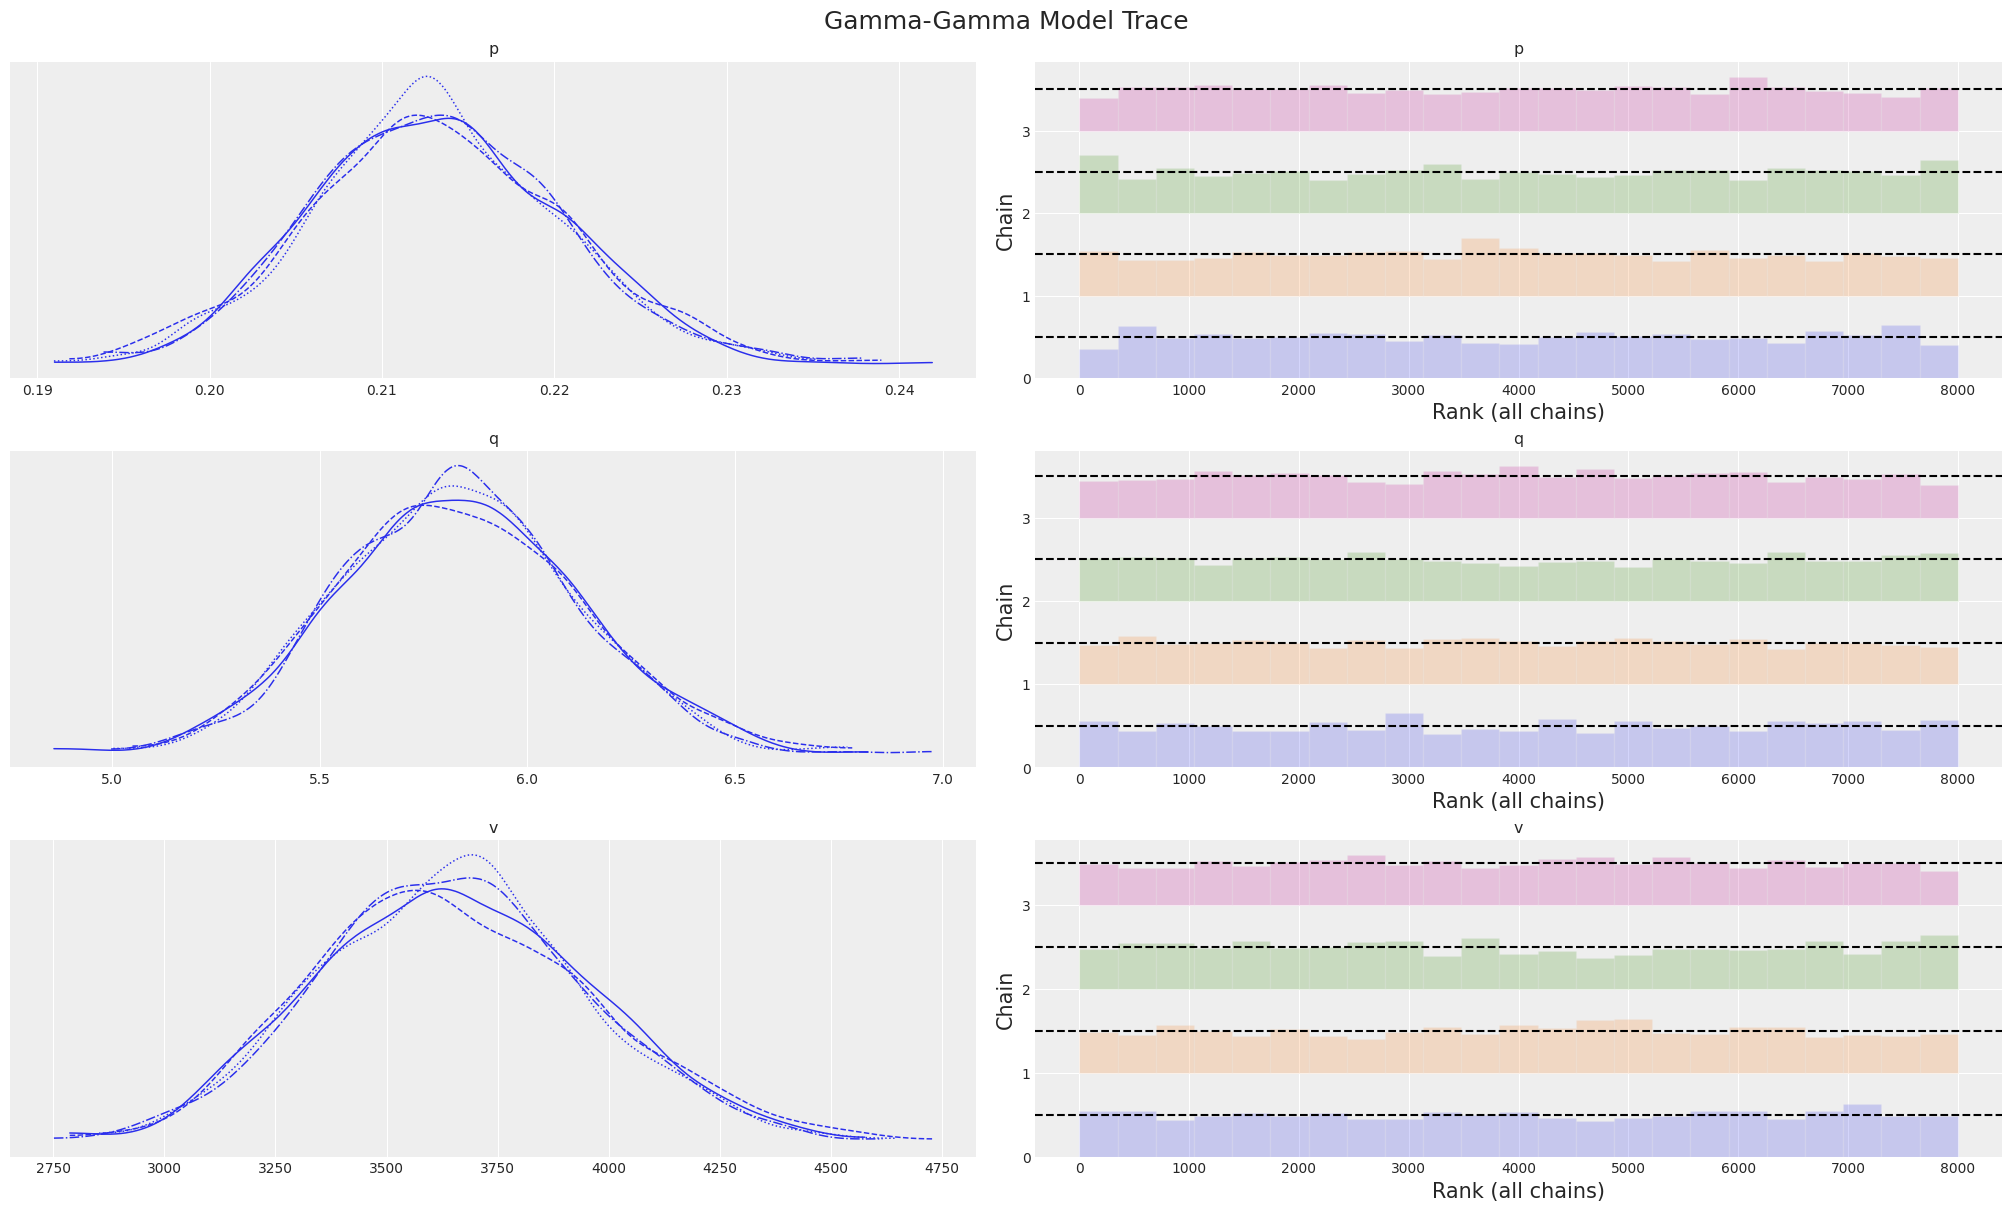

In [214]:
az.plot_trace(
    idata_mcmc_adj,
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (20, 12), "layout": "constrained"},
)
plt.gcf().suptitle(
    "Gamma-Gamma Model Trace",
    fontsize=18,
);

### Comparison: Conditional Expectation of Average Transaction Value For An Account $E(Z \mid p, q, \gamma ; \bar{z}, x)$

In [ ]:
expected_spend_adj: DataArray = gg_model_adj.expected_customer_spend(
    data=train_data_non_zero_adj,
)
summary_adj: pd.DataFrame = az.summary(data=expected_spend_adj, kind="stats")

Join the summary for both models for easier comparison:

In [180]:
summary_joined: pd.DataFrame = pd.concat(
    objs=[summary.sort_index(), summary_adj.sort_index()],
    axis=1,
    keys=["original", "adjusted"],
)

summary_joined

original                          adjusted                  \
                 mean     sd   hdi_3%  hdi_97%     mean     sd   hdi_3%   
x[100088067]  136.793  0.865  135.183  138.420  134.243  1.025  132.336   
x[100108752]  136.145  1.843  132.623  139.536  117.502  2.274  113.326   
x[100328049]  164.403  0.447  163.568  165.216  160.341  0.612  159.199   
x[100663626]  165.755  0.939  163.989  167.465  160.399  1.620  157.589   
x[100737756]  229.676  0.550  228.686  230.748  213.294  1.603  210.237   
...               ...    ...      ...      ...      ...    ...      ...   
x[999086814]  296.378  0.561  295.338  297.399  285.638  1.564  282.717   
x[999257059]  199.900  0.330  199.287  200.519  192.702  0.856  191.129   
x[999258704]  137.655  0.782  136.209  139.136  135.250  0.926  133.524   
x[999283629]  174.721  0.291  174.197  175.282  170.735  0.484  169.834   
x[999389635]  155.007  1.645  151.878  157.994  131.365  2.068  127.466   

                       
              hdi_97%  
x[100088067]  136.138  
x[100108752]  121.767  
x[100328049]  161.481  
x[100663626]  163.585  
x[100737756]  216.198  
...               ...  
x[999086814]  288.553  
x[999257059]  194.292  
x[999258704]  136.961  
x[999283629]  171.632  
x[999389635]  135.120  

[4893 rows x 8 columns]

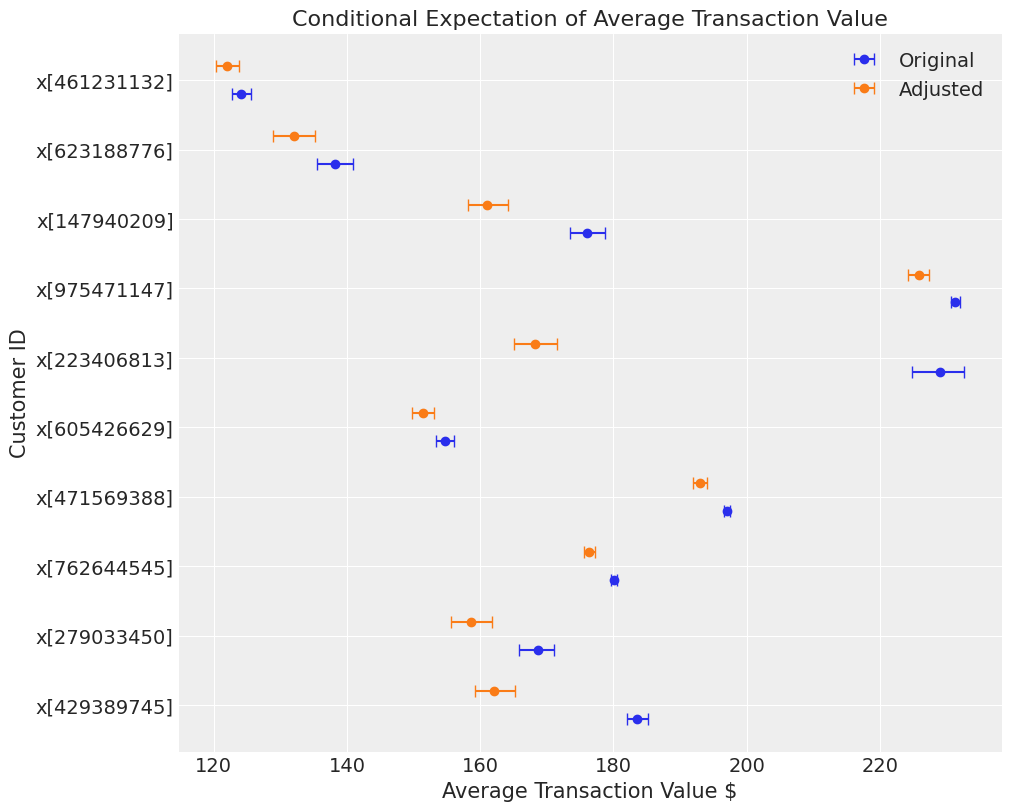

In [192]:
# Sample accounts to plot
accounts: np.ndarray = rng.choice(summary_joined.index, size=10, replace=False).tolist()
sampled_accounts: pd.DataFrame = summary_joined.loc[accounts]

n_accounts: int = len(accounts)
y_positions: np.ndarray = np.arange(n_accounts)

# Define a small offset so the two models don’t overlap exactly
offset: float = 0.2

# Extract statistics for the original estimates
means_orig: pd.Series = sampled_accounts[("original", "mean")]
hdi_lower_orig: pd.Series = sampled_accounts[("original", "hdi_3%")]
hdi_upper_orig: pd.Series = sampled_accounts[("original", "hdi_97%")]

# Extract statistics for the adjusted estimates
means_adj: pd.Series = sampled_accounts[("adjusted", "mean")]
hdi_lower_adj: pd.Series = sampled_accounts[("adjusted", "hdi_3%")]
hdi_upper_adj: pd.Series = sampled_accounts[("adjusted", "hdi_97%")]


fig, ax = plt.subplots(figsize=(10, 8))

ax.errorbar(
    means_orig,
    y_positions - offset,
    xerr=[means_orig - hdi_lower_orig, hdi_upper_orig - means_orig],
    fmt="o",
    color="C0",
    capsize=4,
    label="Original",
)

ax.errorbar(
    means_adj,
    y_positions + offset,
    xerr=[means_adj - hdi_lower_adj, hdi_upper_adj - means_adj],
    fmt="o",
    color="C1",
    capsize=4,
    label="Adjusted",
)

ax.set_yticks(y_positions)
ax.set_yticklabels(accounts)
ax.set_xlabel("Average Transaction Value $")
ax.set_ylabel("Customer ID")
ax.set_title("Conditional Expectation of Average Transaction Value")
ax.legend()
plt.show();

### Comparison: Distribution of Average Transaction Values ($Z$'s) Across All Accounts

In [193]:
mean_expected_spend_adj: DataArray = expected_spend_adj.mean(dim="customer_id")
hdi_prob: float = 0.97
hdi_expected_spend_adj: DataArray = az.hdi(
    expected_spend_adj, hdi_prob=hdi_prob
).to_array()
hdi_lower_adj: float = (
    hdi_expected_spend_adj.sel(hdi="lower").mean(dim="customer_id").item()
)
hdi_upper_adj: float = (
    hdi_expected_spend_adj.sel(hdi="higher").mean(dim="customer_id").item()
)

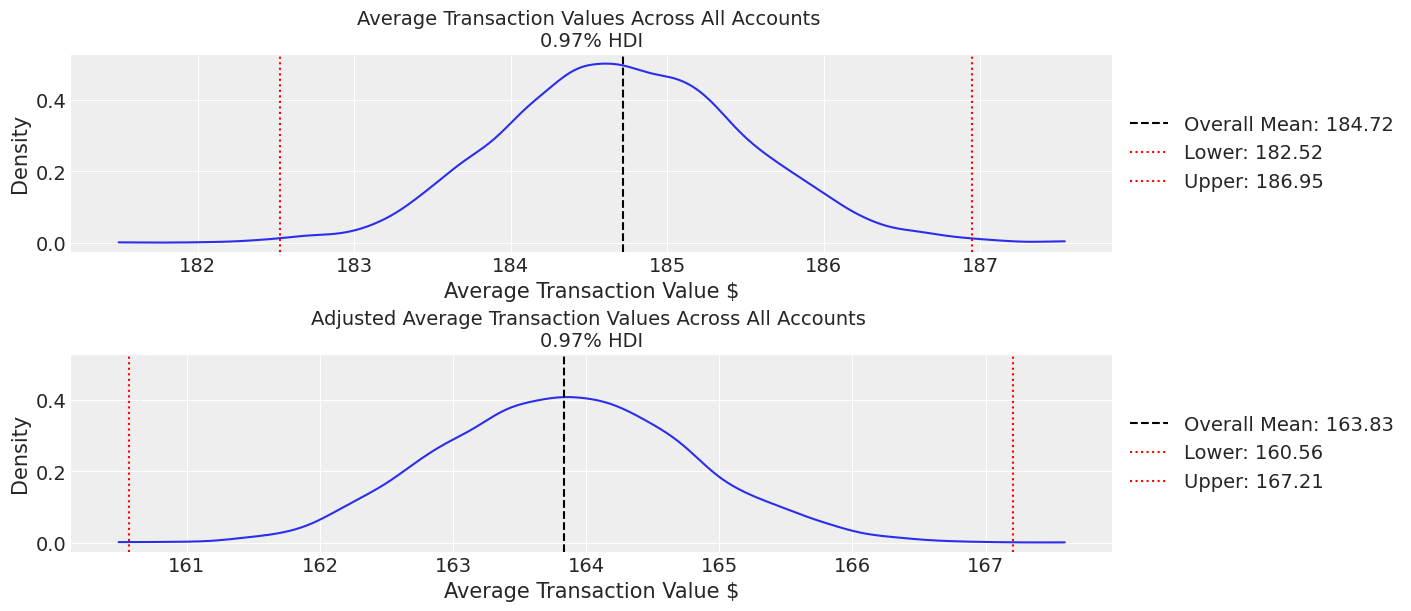

In [196]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 6), sharey=True)

# Plot the original distribution on the first axis
az.plot_dist(mean_expected_spend, ax=ax1)
ax1.axvline(
    x=mean_expected_spend.mean().item(),
    color="black",
    ls="--",
    label=f"Overall Mean: {mean_expected_spend.mean().item():.2f}",
)
ax1.axvline(x=hdi_lower, color="red", linestyle=":", label=f"Lower: {hdi_lower:.2f}")
ax1.axvline(x=hdi_upper, color="red", linestyle=":", label=f"Upper: {hdi_upper:.2f}")
ax1.set(xlabel="Average Transaction Value $", ylabel="Density")
ax1.set_title(
    f"Average Transaction Values Across All Accounts \n{hdi_prob}% HDI", fontsize=14
)
ax1.legend(loc="center left", bbox_to_anchor=(1, 0.5))

# Plot the adjusted distribution on the second axis
az.plot_dist(mean_expected_spend_adj, ax=ax2)
ax2.axvline(
    x=mean_expected_spend_adj.mean().item(),
    color="black",
    ls="--",
    label=f"Overall Mean: {mean_expected_spend_adj.mean().item():.2f}",
)
ax2.axvline(
    x=hdi_lower_adj, color="red", linestyle=":", label=f"Lower: {hdi_lower_adj:.2f}"
)
ax2.axvline(
    x=hdi_upper_adj, color="red", linestyle=":", label=f"Upper: {hdi_upper_adj:.2f}"
)
ax2.set(xlabel="Average Transaction Value $", ylabel="Density")
ax2.set_title(
    f"Adjusted Average Transaction Values Across All Accounts \n{hdi_prob}% HDI",
    fontsize=14,
)
ax2.legend(loc="center left", bbox_to_anchor=(1, 0.5))

plt.show();

#### Comparison: Population‐Level (Prior) Mean of $\zeta$

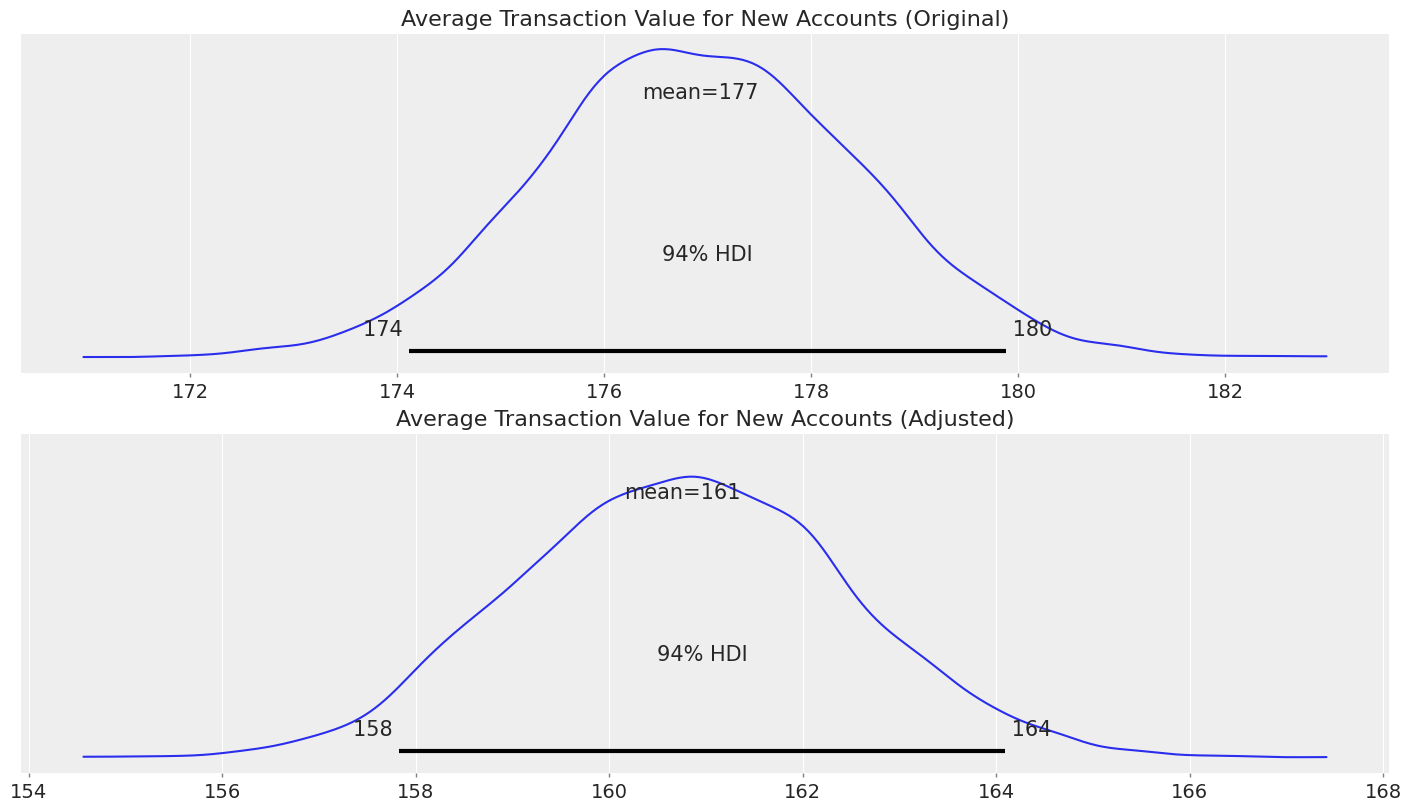

In [198]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharey=True)

# Plot the original distribution on the first axis
az.plot_posterior(data=gg_model.expected_new_customer_spend(), ax=ax1)

# Plot the adjusted distribution on the second axis
az.plot_posterior(data=gg_model_adj.expected_new_customer_spend(), ax=ax2)

ax1.set_title("Average Transaction Value for New Accounts (Original)")
ax2.set_title("Average Transaction Value for New Accounts (Adjusted)");

### Comparison: Customer Lifetime Value (CLV)

In [ ]:
pnbd_model: ParetoNBDModel = ParetoNBDModel.load(
    str(model_path / "pnbd_model_thin_20.nc")
)

gg_model_adj: GammaGammaModel = GammaGammaModel.load(
    str(model_path / "gg_model_adj.nc")
)

In [203]:
future_t_in_months: int = 12
monthly_discount_rate: float = 0.01

clv_estimates_adj: DataArray = gg_model_adj.expected_customer_lifetime_value(
    transaction_model=pnbd_model,
    data=train_data,
    future_t=future_t_in_months,  # This must be in months
    discount_rate=monthly_discount_rate,  # This also must be in months
    time_unit="D",
)

clv_summaries_adj: pd.DataFrame = az.summary(data=clv_estimates_adj, kind="stats")

Join the CLV estimates for both models:

In [244]:
clv_summaries_joined: pd.DataFrame = pd.concat(
    objs=[clv_summaries.sort_index(), clv_summaries_adj.sort_index()],
    axis=1,
    keys=["original", "adjusted"],
)

clv_summaries_joined

original                                 adjusted          \
                   mean      sd     hdi_3%    hdi_97%       mean      sd   
x[100088067]   8135.667   2.163   8131.731   8139.576   7890.730   2.098   
x[100108752]   3657.101   3.888   3649.810   3664.309   3431.864   3.648   
x[100328049]  12456.966   3.152  12451.175  12462.796  12144.845   3.073   
x[100663626]   3789.523   2.818   3784.591   3795.058   3591.694   2.671   
x[100737756]  27673.423   7.843  27658.485  27687.909  27188.231   7.705   
...                 ...     ...        ...        ...        ...     ...   
x[999086814]  79243.667  26.639  79197.232  79296.470  78558.245  26.409   
x[999257059]  24244.892   6.860  24231.335  24257.040  23824.018   6.741   
x[999258704]   8898.625   2.228   8894.569   8902.639   8652.269   2.166   
x[999283629]  19323.257   5.220  19313.436  19332.693  18967.629   5.124   
x[999389635]   1314.632   3.579   1307.809   1321.127   1216.099   3.311   

                                    
                 hdi_3%    hdi_97%  
x[100088067]   7886.912   7894.521  
x[100108752]   3425.022   3438.628  
x[100328049]  12139.200  12150.530  
x[100663626]   3587.019   3596.940  
x[100737756]  27173.555  27202.463  
...                 ...        ...  
x[999086814]  78512.211  78610.591  
x[999257059]  23810.695  23835.954  
x[999258704]   8648.325   8656.172  
x[999283629]  18957.989  18976.892  
x[999389635]   1209.788   1222.108  

[4961 rows x 8 columns]

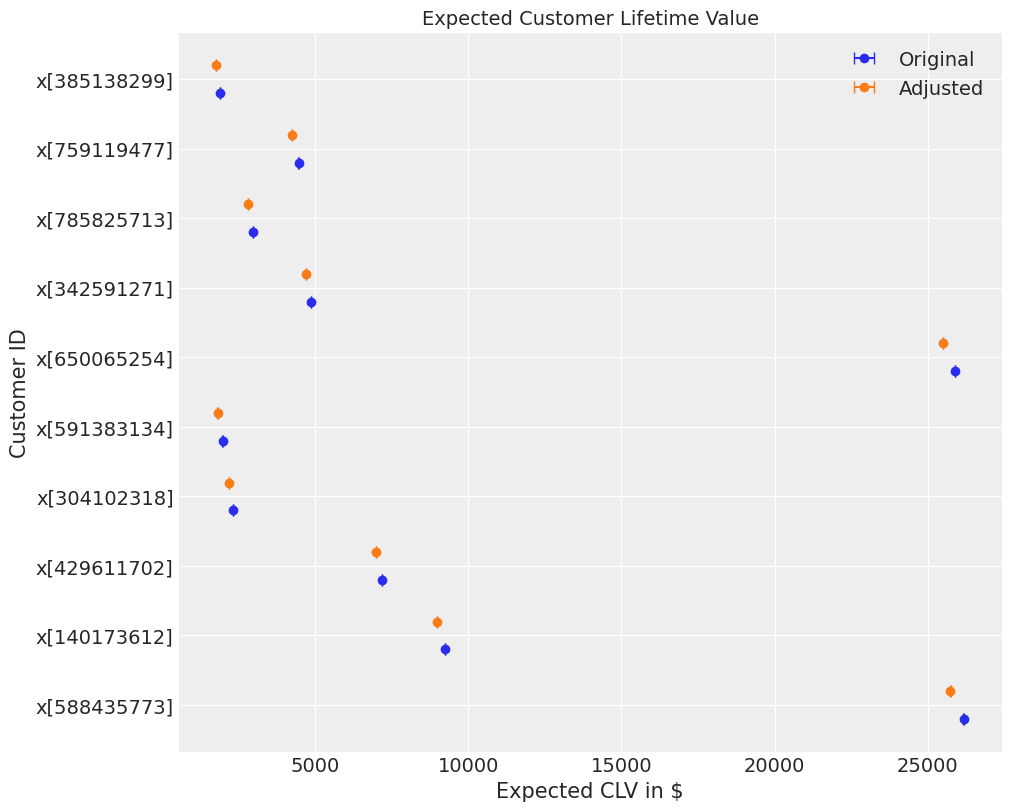

In [215]:
accounts_clv: np.ndarray = rng.choice(
    clv_summaries_joined.index, size=10, replace=False
).tolist()
sampled_accounts_clv: pd.DataFrame = clv_summaries_joined.loc[accounts_clv]

n_accounts_clv = len(accounts_clv)
y_positions_clv = np.arange(n_accounts_clv)

offset_clv = 0.2

means_orig_clv = sampled_accounts_clv[("original", "mean")]
hdi_lower_orig_clv = sampled_accounts_clv[("original", "hdi_3%")]
hdi_upper_orig_clv = sampled_accounts_clv[("original", "hdi_97%")]

means_adj_clv = sampled_accounts_clv[("adjusted", "mean")]
hdi_lower_adj_clv = sampled_accounts_clv[("adjusted", "hdi_3%")]
hdi_upper_adj_clv = sampled_accounts_clv[("adjusted", "hdi_97%")]

fig, ax = plt.subplots(figsize=(10, 8))

ax.errorbar(
    means_orig_clv,
    y_positions_clv - offset_clv,
    xerr=[means_orig_clv - hdi_lower_orig_clv, hdi_upper_orig_clv - means_orig_clv],
    fmt="o",
    color="C0",
    capsize=4,
    label="Original",
)

ax.errorbar(
    means_adj_clv,
    y_positions_clv + offset_clv,
    xerr=[means_adj_clv - hdi_lower_adj_clv, hdi_upper_adj_clv - means_adj_clv],
    fmt="o",
    color="C1",
    capsize=4,
    label="Adjusted",
)

ax.set_yticks(y_positions_clv)
ax.set_yticklabels(accounts_clv)
ax.set_xlabel("Expected CLV in $")
ax.set_ylabel("Customer ID")
ax.set_title(
    "Expected Customer Lifetime Value",
    fontsize=14,
)
ax.legend()
plt.show();

### Ranks of Accounts by CLV

We create (dense) ranks for each model based on the estimated CLV, where higher estimated CLV values correspond to higher (smaller absolute) ranks:

In [245]:
clv_summaries_joined[("original", "rank")] = clv_summaries_joined[
    ("original", "mean")
].rank(method="dense", ascending=False)
clv_summaries_joined[("adjusted", "rank")] = clv_summaries_joined[
    ("adjusted", "mean")
].rank(method="dense", ascending=False)

clv_summaries_joined

original                                 adjusted          \
                   mean      sd     hdi_3%    hdi_97%       mean      sd   
x[100088067]   8135.667   2.163   8131.731   8139.576   7890.730   2.098   
x[100108752]   3657.101   3.888   3649.810   3664.309   3431.864   3.648   
x[100328049]  12456.966   3.152  12451.175  12462.796  12144.845   3.073   
x[100663626]   3789.523   2.818   3784.591   3795.058   3591.694   2.671   
x[100737756]  27673.423   7.843  27658.485  27687.909  27188.231   7.705   
...                 ...     ...        ...        ...        ...     ...   
x[999086814]  79243.667  26.639  79197.232  79296.470  78558.245  26.409   
x[999257059]  24244.892   6.860  24231.335  24257.040  23824.018   6.741   
x[999258704]   8898.625   2.228   8894.569   8902.639   8652.269   2.166   
x[999283629]  19323.257   5.220  19313.436  19332.693  18967.629   5.124   
x[999389635]   1314.632   3.579   1307.809   1321.127   1216.099   3.311   

                                   original adjusted  
                 hdi_3%    hdi_97%     rank     rank  
x[100088067]   7886.912   7894.521   2004.0   1999.0  
x[100108752]   3425.022   3438.628   3295.0   3308.0  
x[100328049]  12139.200  12150.530   1456.0   1456.0  
x[100663626]   3587.019   3596.940   3230.0   3225.0  
x[100737756]  27173.555  27202.463    707.0    712.0  
...                 ...        ...      ...      ...  
x[999086814]  78512.211  78610.591    185.0    185.0  
x[999257059]  23810.695  23835.954    802.0    803.0  
x[999258704]   8648.325   8656.172   1870.0   1866.0  
x[999283629]  18957.989  18976.892    980.0    981.0  
x[999389635]   1209.788   1222.108   4648.0   4645.0  

[4961 rows x 10 columns]

#### Top 10 Accounts by Both Models

In [246]:
clv_summaries_joined[
    (clv_summaries_joined[("original", "rank")] <= 10)
    & (clv_summaries_joined[("adjusted", "rank")] <= 10)
]

original                                         adjusted  \
                     mean        sd       hdi_3%      hdi_97%         mean   
x[208319653]   608762.578   211.484   608383.748   609173.605   604402.999   
x[246251253]  1222610.060   424.734  1221849.236  1223435.545  1213846.845   
x[369308035]   861402.807   299.251   860866.761   861984.412   855230.831   
x[380680241]  3857637.888  1340.140  3855237.299  3860242.499  3829971.437   
x[419709514]   698626.240   242.702   698191.488   699097.940   693621.994   
x[570884863]  1307887.664   454.359  1307073.772  1308770.727  1298512.681   
x[724518977]   745408.212   258.954   744944.348   745911.499   740068.360   
x[832842201]   725956.325   252.197   725504.566   726446.479   720756.018   
x[882815134]  1616434.230   561.548  1615428.331  1617525.619  1604845.788   
x[894938833]   735778.263   255.609   735320.392   736275.048   730507.495   

                                                 original adjusted  
                    sd       hdi_3%      hdi_97%     rank     rank  
x[208319653]   209.969   604026.882   604811.082     10.0     10.0  
x[246251253]   421.689  1213091.474  1214666.413      4.0      4.0  
x[369308035]   297.106   854698.625   855808.268      5.0      5.0  
x[380680241]  1330.529  3827588.064  3832557.368      1.0      1.0  
x[419709514]   240.964   693190.356   694090.316      9.0      9.0  
x[570884863]   451.102  1297704.623  1299389.415      3.0      3.0  
x[724518977]   257.099   739607.820   740568.042      6.0      6.0  
x[832842201]   250.390   720307.496   721242.661      8.0      8.0  
x[882815134]   557.522  1603847.100  1605929.352      2.0      2.0  
x[894938833]   253.778   730052.904   731000.722      7.0      7.0

#### Accounts Whose CLV Ranks Dropped Significantly After Adjustment to Frequency

In [247]:
clv_summaries_joined[("rank_difference", "")] = (
    clv_summaries_joined[("original", "rank")]
    - clv_summaries_joined[("adjusted", "rank")]
)

clv_summaries_joined.loc[
    clv_summaries_joined[("rank_difference", "")] > 10,
    [
        ("original", "rank"),
        ("adjusted", "rank"),
        ("original", "mean"),
        ("adjusted", "mean"),
        ("rank_difference", ""),
    ],
]

,original,adjusted,original,adjusted,rank_difference
,rank,rank,mean,mean,
x[101339369],3474.0,3461.0,3298.001,3148.583,13.0
x[101537721],3842.0,3824.0,2620.936,2484.043,18.0
x[103479817],3627.0,3608.0,2986.191,2837.777,19.0
x[103522202],3663.0,3650.0,2920.899,2772.125,13.0
x[105418907],1495.0,1482.0,12148.813,11931.154,13.0
...,...,...,...,...,...
x[989738601],2989.0,2973.0,4315.817,4155.837,16.0
x[990579736],2434.0,2420.0,6076.767,5879.734,14.0
x[991432558],3959.0,3941.0,2426.436,2296.374,18.0


#### Top and Bottom X Accounts Across Both Models

In [251]:
total_accounts: int = train_data.shape[0]

top_10_threshold: float = total_accounts * 0.10
bottom_10_threshold: float = total_accounts * 0.90

# Original CLV
top_10_original: pd.Index = clv_summaries_joined[
    clv_summaries_joined[("original", "rank")] <= top_10_threshold
].index
bottom_10_original: pd.Index = clv_summaries_joined[
    clv_summaries_joined[("original", "rank")] > bottom_10_threshold
].index

# Adjusted CLV
top_10_adjusted: pd.Index = clv_summaries_joined[
    clv_summaries_joined[("adjusted", "rank")] <= top_10_threshold
].index
bottom_10_adjusted: pd.Index = clv_summaries_joined[
    clv_summaries_joined[("adjusted", "rank")] > bottom_10_threshold
].index

combined_top_10: pd.Index = top_10_original.intersection(top_10_adjusted)
combined_bottom_10: pd.Index = bottom_10_original.intersection(bottom_10_adjusted)

combined_top_10_data: pd.DataFrame = clv_summaries_joined.loc[combined_top_10]
combined_bottom_10_data: pd.DataFrame = clv_summaries_joined.loc[combined_bottom_10]

combined_top_10_data
combined_bottom_10_data

original                                    adjusted          \
                    mean      sd      hdi_3%     hdi_97%        mean      sd   
x[101738384]   44311.257  13.573   44287.687   44338.037   43743.251  13.399   
x[102755773]   50856.474  16.365   50828.083   50889.203   50306.209  16.188   
x[105730883]   52142.481  16.758   52113.377   52176.037   51575.158  16.576   
x[106159813]  120023.136  41.320  119949.216  120103.347  119117.066  41.008   
x[107682678]   56435.616  18.512   56402.401   56471.472   55884.935  18.331   
...                  ...     ...         ...         ...         ...     ...   
x[991911879]   68913.473  22.981   68873.518   68959.004   68292.363  22.774   
x[995920358]   85445.196  29.036   85394.417   85502.850   84749.163  28.799   
x[996362843]  162778.165  56.226  162677.530  162887.173  161572.821  55.809   
x[996709868]   48970.886  15.728   48943.639   49002.290   48446.752  15.560   
x[999086814]   79243.667  26.639   79197.232   79296.470   78558.245  26.409   

                                     original adjusted rank_difference  
                  hdi_3%     hdi_97%     rank     rank                  
x[101738384]   43719.983   43769.688    415.0    416.0            -1.0  
x[102755773]   50278.125   50338.585    353.0    353.0             0.0  
x[105730883]   51546.371   51608.348    340.0    341.0            -1.0  
x[106159813]  119043.704  119196.672    104.0    104.0             0.0  
x[107682678]   55852.044   55920.441    298.0    297.0             1.0  
...                  ...         ...      ...      ...             ...  
x[991911879]   68252.768   68337.484    222.0    222.0             0.0  
x[995920358]   84698.797   84806.347    167.0    166.0             1.0  
x[996362843]  161472.930  161681.021     78.0     78.0             0.0  
x[996709868]   48419.796   48477.820    366.0    366.0             0.0  
x[999086814]   78512.211   78610.591    185.0    185.0             0.0  

[496 rows x 11 columns]

original                             adjusted                   \
                  mean     sd    hdi_3%   hdi_97%      mean     sd    hdi_3%   
x[105499749]   732.993  4.251   725.314   741.084   671.466  3.895   664.432   
x[105518929]  1560.916  3.641  1553.920  1567.468  1448.215  3.379  1441.725   
x[109585094]  1346.918  3.687  1339.775  1353.481  1246.047  3.411  1239.438   
x[110169390]  1006.723  4.287   998.908  1014.815   925.523  3.941   918.337   
x[110625245]   307.849  5.540   297.891   318.452   279.713  5.034   270.665   
...                ...    ...       ...       ...       ...    ...       ...   
x[994092092]   508.143  4.498   500.046   516.755   463.673  4.104   456.285   
x[994684268]  1210.028  3.346  1203.701  1216.150  1119.393  3.095  1113.539   
x[998706877]  1527.637  4.182  1519.535  1535.081  1413.382  3.869  1405.886   
x[998869994]   939.546  3.990   932.282   947.069   863.661  3.668   856.984   
x[999389635]  1314.632  3.579  1307.809  1321.127  1216.099  3.311  1209.788   

                       original adjusted rank_difference  
               hdi_97%     rank     rank                  
x[105499749]   678.878   4844.0   4841.0             3.0  
x[105518929]  1454.294   4524.0   4522.0             2.0  
x[109585094]  1252.118   4631.0   4624.0             7.0  
x[110169390]   932.962   4760.0   4758.0             2.0  
x[110625245]   289.347   4938.0   4936.0             2.0  
...                ...      ...      ...             ...  
x[994092092]   471.532   4900.0   4898.0             2.0  
x[994684268]  1125.056   4685.0   4681.0             4.0  
x[998706877]  1420.269   4543.0   4542.0             1.0  
x[998869994]   870.577   4781.0   4778.0             3.0  
x[999389635]  1222.108   4648.0   4645.0             3.0  

[494 rows x 11 columns]

#### Detecting Significant Outliers or Model Shifts

Accounts that were ranked very differently by the two models may indicate significant uncertainty:

In [258]:
top_x_threshold = total_accounts * 0.25
bottom_x_threshold = total_accounts * 0.75

# Ranked top X% in the original model
top_x_original: pd.Index = clv_summaries_joined[
    clv_summaries_joined[("original", "rank")] <= top_x_threshold
].index

# Ranked bottom X% in the adjusted model
bottom_x_adjusted: pd.Index = clv_summaries_joined[
    clv_summaries_joined[("adjusted", "rank")] > bottom_x_threshold
].index

significant_shifts: pd.Index = top_x_original.intersection(bottom_x_adjusted)

significant_shifts_data: pd.DataFrame = clv_summaries_joined.loc[significant_shifts]

significant_shifts_data

Empty DataFrame
Columns: [(original, mean), (original, sd), (original, hdi_3%), (original, hdi_97%), (adjusted, mean), (adjusted, sd), (adjusted, hdi_3%), (adjusted, hdi_97%), (original, rank), (adjusted, rank), (rank_difference, )]
Index: []